# Comic Ray simulation for IMCOM


In [1]:
# Python imports
%matplotlib inline 
%matplotlib ipympl

import pdb
import math
import heapq
import IPython
import itertools
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D 
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from sympy import symbols, solve
from ipywidgets import interact
from scipy.stats import norm
from itertools import chain
from tqdm import tqdm

C:\Users\Owner\anaconda3\envs\8820-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def mean_excitation_energy_HgCdTe(x):
    """
    Calculate the mean excitation energy for Hg_(1-x)Cd_(x)Te using Bragg's sum rule.
    
    Parameters:
        x (float): Fraction of Cd (0 <= x <= 1). The Hg fraction is (1-x).
    
    Returns:
        float: The effective mean excitation energy (in eV) for the compound.
    """
    # Mean excitation energies for the elements (in eV), data taken from https://physics.nist.gov/PhysRefData/Star/Text/method.html
    I_Hg = 800.0  # in eV, from NIST: https://pml.nist.gov/cgi-bin/Star/compos.pl?matno=080
    I_Cd = 469.0  # in eV, from NIST: https://pml.nist.gov/cgi-bin/Star/compos.pl?matno=048
    I_Te = 485.0  # in eV, from NIST: https://pml.nist.gov/cgi-bin/Star/compos.pl?matno=052
    
    # Atomic numbers (number of electrons per atom)
    Z_Hg = 80
    Z_Cd = 48
    Z_Te = 52

    # Electrons contributed by each element in the formula unit Hg_(1-x)Cd_(x)Te
    electrons_Hg = (1 - x) * Z_Hg
    electrons_Cd = x * Z_Cd
    electrons_Te = Z_Te 

    # Total number of electrons in the formula unit
    total_electrons = electrons_Hg + electrons_Cd + electrons_Te

    # Weighting factors based on electron contribution
    w_Hg = electrons_Hg / total_electrons
    w_Cd = electrons_Cd / total_electrons
    w_Te = electrons_Te / total_electrons

    # Compute the logarithmic average (Bragg's rule):
    lnI = w_Hg * np.log(I_Hg) + w_Cd * np.log(I_Cd) + w_Te * np.log(I_Te)
    I_compound = np.exp(lnI)
    
    return I_compound

def radiation_length_HgCdTe(x):
    """
    Compute the radiation length (in g/cm^2) for Hg(1-x)Cd(x)Te.
    
    Uses the PDG approximate formula for the radiation length of an element:
    
        X0 = 716.4 * A / (Z*(Z+1)*ln(287/sqrt(Z)))   [g/cm^2]
    
    and for a compound:
    
        1/X0_compound = sum_i (w_i / X0_i)
        
    where w_i = (N_i * A_i) / (sum_j N_j * A_j) are the weight fractions.
    
    Parameters
    ----------
    x : float
        Molar fraction of Cd (and thus Hg molar fraction is 1-x).
    
    Returns
    -------
    X0_compound : float
        Radiation length of the compound in g/cm^2.
    """
    # Atomic numbers and atomic masses (g/mol) for each element:
    # Mercury (Hg)
    Z_Hg = 80
    A_Hg = 200.59  
    # Cadmium (Cd)
    Z_Cd = 48
    A_Cd = 112.41  
    # Tellurium (Te)
    Z_Te = 52
    A_Te = 127.60  
    
    # Helper function: Radiation length for an element (in g/cm^2)
    def X0_element(Z, A):
        return 716.4 * A / (Z * (Z + 1) * np.log(287/np.sqrt(Z)))
    
    # Compute radiation lengths for individual elements:
    X0_Hg = X0_element(Z_Hg, A_Hg)
    X0_Cd = X0_element(Z_Cd, A_Cd)
    X0_Te = X0_element(Z_Te, A_Te)
    
    # Molar amounts: Hg: (1-x), Cd: x, Te: 1.
    # Total molar mass of the compound:
    A_tot = (1 - x) * A_Hg + x * A_Cd + A_Te
    
    # Weight fractions:
    w_Hg = (1 - x) * A_Hg / A_tot
    w_Cd = x * A_Cd / A_tot
    w_Te = A_Te / A_tot
    
    # Radiation length of the compound (in g/cm^2):
    X0_compound = 1.0 / (w_Hg / X0_Hg + w_Cd / X0_Cd + w_Te / X0_Te)
    
    return X0_compound

def density_HgCdTe(x):
    """
    Compute the density (in g/cm^3) of Hg(1-x)Cd(x)Te.
    
    Assumes:
      - Formula unit: 1 cation (Hg with fraction 1-x or Cd with fraction x) + 1 Te.
      - Zincblende crystal structure (4 formula units per unit cell).
      - Vegard's law for the lattice constant.
    
    Parameters
    ----------
    x : float
        Molar fraction of Cd (and thus Hg molar fraction is 1-x).
    
    Returns
    -------
    density : float
        Density of Hg(1-x)Cd(x)Te in g/cm^3.
    """
    # Atomic masses in g/mol
    A_Hg = 200.59   # Mercury
    A_Cd = 112.41   # Cadmium
    A_Te = 127.60   # Tellurium
    
    # Molar mass of the compound (g/mol)
    M = (1 - x) * A_Hg + x * A_Cd + A_Te
    
    # Lattice constants (in cm) - 1 Å = 1e-8 cm
    a_HgTe = 6.46e-8  # HgTe lattice constant in cm
    a_CdTe = 6.48e-8  # CdTe lattice constant in cm
    
    # Vegard's law: linear interpolation of lattice constant
    a = (1 - x) * a_HgTe + x * a_CdTe
    
    # For zincblende structure: 4 formula units per unit cell
    # Volume per formula unit = a^3 / 4
    volume_per_formula = a**3 / 4
    
    # Avogadro's number (mol^-1)
    N_A = 6.02214076e23
    
    # Mass per formula unit in grams
    mass_per_formula = M / N_A
    
    # Density in g/cm^3
    density = mass_per_formula / volume_per_formula
    
    return density

def mean_Z_A_HgCdTe(x):
    """
    Compute the number-averaged mean atomic number (Z) and atomic mass (A)
    for Hg(1-x)Cd(x)Te in a zincblende structure.
    
    Parameters:
    -----------
    x : float
        Molar fraction of Cd (and hence Hg fraction is 1-x).
    
    Returns:
    --------
    Z_mean : float
        Number-averaged mean atomic number.
    A_mean : float
        Number-averaged mean atomic mass (in g/mol).
    """
    # Atomic numbers
    Z_Hg = 80
    Z_Cd = 48
    Z_Te = 52

    # Atomic masses in g/mol
    A_Hg = 200.59
    A_Cd = 112.41
    A_Te = 127.60

    # There are (1-x) moles of Hg, x moles of Cd, and 1 mole of Te per formula unit.
    # Total number of atoms per formula unit = (1-x) + x + 1 = 2.
    total_atoms = 2

    Z_mean = ((1 - x) * Z_Hg + x * Z_Cd + Z_Te) / total_atoms
    A_mean = ((1 - x) * A_Hg + x * A_Cd + A_Te) / total_atoms

    return Z_mean, A_mean

# Compute material properties for Hg0.555Cd0.445Te (x = 0.445)
x = 0.445 # molar fraction of Cd in Hg(1-x)Cd(x)Te
I_value = mean_excitation_energy_HgCdTe(x)
I_value_MeV = I_value*(1e-6)
print(f"Mean excitation energy for Hg0.555Cd0.445Te: {I_value:.2f} eV = {I_value_MeV:.3e} MeV")
  
X0_gPercmSqd = radiation_length_HgCdTe(x)
print("Radiation length (in g/cm^2) for Hg(1-x)Cd(x)Te (x = {:.3f}) = {:.2f} g/cm^2".format(x, X0_gPercmSqd))

HgCdTe_density = density_HgCdTe(x)
print("Density for Hg(1-x)Cd(x)Te with x = {:.3f} is {:.2f} g/cm³".format(x, HgCdTe_density))
X0_cm=X0_gPercmSqd/HgCdTe_density
print(f'So, the radiation length is X0 = {X0_cm:.2g} cm')

Z_mean, A_mean = mean_Z_A_HgCdTe(x)
print(f"For Hg(1-x)Cd(x)Te with x = {x:.3f}:")
print(f"  Mean Z = {Z_mean:.2f}")
print(f"  Mean A = {A_mean:.2f} g/mol")

color_list = []
with open('rgb_color_list.txt', 'r') as file:
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        if not line or line.startswith('#'):
            continue  # Skip blank lines or comment lines
        # Split the line by tab. Adjust the separator if needed.
        parts = line.split('\t')
        if len(parts) < 2:
            continue  # Skip lines that don't have enough parts
        color_name = parts[0].strip()
        hex_code = parts[1].strip()
        color_list.append((color_name, hex_code))

# Reading in sunspot data to compute ISO parameters and rigidity spectrum
# Sunspot data downloaded from https://www.sidc.be/SILSO/datafiles
month_df = pd.read_csv('SN_m_tot_V2.0.csv', sep='\;', engine = 'python')
month_s_df = pd.read_csv('SN_ms_tot_V2.0.csv', sep='\;', engine = 'python')

#Contents:
  #Column 1-2: Gregorian calendar date, 1.Year, 2.Month
  #Column 3: Date in fraction of year for the middle of the corresponding month
  #Column 4: Monthly mean total sunspot number, W = Ns + 10 * Ng, with Ns the number of spots
   # and Ng the number of groups counted over the entire solar disk
  #Column 5: Monthly mean standard deviation of the input sunspot numbers from individual stations.
  #Column 6: Number of observations used to compute the monthly mean total sunspot number.
  #Column 7: Definitive/provisional marker.

month_df.columns = ['year', 'month', 'date' ,'mean', 'std_dev','num_obs','marker']
month_s_df.columns = ['year', 'month', 'date' ,'mean', 'std_dev','num_obs','marker']

frac_amounts = [0.042, 0.123, 0.204, 0.288, 0.371, 0.455, 0.538, 0.623, 0.707, 0.790, 0.874, 0.958]
t_plus = 1 + (frac_amounts[2] + frac_amounts[3])*(1/2)
delta_w_t = 1 + (frac_amounts[3] + frac_amounts[4])*(1/2)

# IF USING SMOOTHED DATA INSTEAD, USE THE FOLLOWING BLOCK:-----
#month_df=month_s_df
#month_df=month_df[:-7]
# -------------------------------------------------------------

# Filter the dataframe to include only dates starting at 1986.707
month_df = month_df[month_df['date'] >= 1986.707].copy()

# Initialize 'solar_cycle' and update according to date ranges:
month_df['solar_cycle'] = 22
month_df.loc[(month_df['date'] >= 1996.624) & (month_df['date'] <= 2008.874), 'solar_cycle'] = 23
month_df.loc[(month_df['date'] >= 2008.958) & (month_df['date'] <= 2019.873), 'solar_cycle'] = 24
month_df.loc[month_df['date'] >= 2019.958, 'solar_cycle'] = 25

# Define the dates where the solar cycle changes
cycle_change_dates = [1996.624, 2008.958, 2019.958]
cycle_labels = ['Cycle 23 starts', 'Cycle 24 starts', 'Cycle 25 starts']

# For each solar cycle, find the row with the maximum and minimum 'mean'
cycle_max = month_df.loc[month_df.groupby("solar_cycle")["mean"].idxmax()]
cycle_min = month_df.loc[month_df.groupby("solar_cycle")["mean"].idxmin()]

month_df['cycle_max'] = month_df.groupby('solar_cycle')['mean'].transform('max')
month_df['cycle_min'] = month_df.groupby('solar_cycle')['mean'].transform('min')

# Group the dataframe by 'solar_cycle' and find the index of the row with the maximum 'mean' for each group
cycle_max_df = month_df.loc[month_df.groupby("solar_cycle")["mean"].idxmax()]
# First, extract the sign reversal moments by finding, for each solar cycle, 
# the date at which the 'mean' is maximum.
cycle_max_df = month_df.loc[month_df.groupby("solar_cycle")["mean"].idxmax()]

# Create a mapping: solar_cycle -> sign reversal moment (date)
sign_reversal_dict = cycle_max_df.set_index('solar_cycle')['date'].to_dict()

def compute_M(target_date, df, sign_reversal_dict, tol=3e-2):
    """
    Given a target date and a dataframe (with a 'date' column and solar cycle columns),
    this function finds the entry whose 'date' is within a tolerance of target_date,
    and then computes:
    
    M = S * (-1)^(solar_cycle - 1) * ((mean - cycle_min) / (cycle_max - cycle_min))^2.7
    
    where S = 1 if (target_date - sign_reversal_date) >= 0,
          S = -1 otherwise.
    
    Parameters:
      target_date (float): The date (fraction of year) to search for.
      df (pd.DataFrame): DataFrame containing the data.
      sign_reversal_dict (dict): Dictionary mapping solar_cycle to its sign reversal date.
      tol (float): Tolerance for matching the date.
    
    Returns:
      float: The computed M value for the matching entry.
    
    Raises:
      ValueError: If no entry is found within the tolerance.
    """
    # Find the row whose 'date' is closest to target_date
    diff = np.abs(df['date'] - target_date)
    if diff.min() > tol:
        raise ValueError(f"No entry found for date {target_date} within tolerance {tol}.")
    idx = diff.idxmin()
    row = df.loc[idx]
    
    # Extract values from the row
    solar_cycle = row['solar_cycle']
    mean_val = row['mean']
    cycle_max_val = row['cycle_max']
    cycle_min_val = row['cycle_min']
    
    # Check for division by zero
    if cycle_max_val == cycle_min_val:
        raise ValueError("cycle_max and cycle_min are equal; cannot compute fraction.")
    
    fraction = (mean_val - cycle_min_val) / (cycle_max_val - cycle_min_val)
    
    # Compute the sign factor from solar_cycle
    factor = (-1)**(int(solar_cycle) - 1)
    
    # Compute S based on the target_date relative to the sign reversal moment for that cycle
    sign_reversal = sign_reversal_dict[solar_cycle]
    S = 1 if (target_date - sign_reversal) >= 0 else -1
    
    # Compute M using the modified formula
    M_value = S * factor * (fraction**2.7)
    return M_value

# Now, apply compute_M over the dataframe. 
# For each row (using its 'date'), compute the corresponding M_value.
month_df['M_value'] = month_df['date'].apply(lambda d: compute_M(d, month_df, sign_reversal_dict, tol=1e-2))

class CosmicRaySimulation:
    # Class-level lists for species (charge and mass)
    Z_list = [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
              21, 22, 23, 24, 25, 26, 27, 28]
    m_list = [5.109989461e5, 0.9382720813e9, 2*(0.9382720813e9) + 2*(0.9395654133e9),3*(0.9382720813e9) + 4*(0.9395654133e9), 
              4*(0.9382720813e9) + 5*(0.9395654133e9),5*(0.9382720813e9) + 6*(0.9395654133e9), 6*(0.9382720813e9) + 6*(0.9395654133e9),
              7*(0.9382720813e9) + 7*(0.9395654133e9), 8*(0.9382720813e9) + 8*(0.9395654133e9), 9*(0.9382720813e9) + 10*(0.9395654133e9), 
              10*(0.9382720813e9) + 10*(0.9395654133e9), 11*(0.9382720813e9) + 12*(0.9395654133e9), 12*(0.9382720813e9) + 12*(0.9395654133e9), 
              13*(0.9382720813e9) + 14*(0.9395654133e9), 14*(0.9382720813e9) + 14*(0.9395654133e9), 15*(0.9382720813e9) + 16*(0.9395654133e9), 
              16*(0.9382720813e9) + 16*(0.9395654133e9), 17*(0.9382720813e9) + 18*(0.9395654133e9), 18*(0.9382720813e9) + 22*(0.9395654133e9),
              19*(0.9382720813e9) + 20*(0.9395654133e9), 20*(0.9382720813e9) + 20*(0.9395654133e9), 21*(0.9382720813e9) + 24*(0.9395654133e9),
              22*(0.9382720813e9) + 26*(0.9395654133e9), 23*(0.9382720813e9) + 28*(0.9395654133e9), 24*(0.9382720813e9) + 28*(0.9395654133e9),
              25*(0.9382720813e9) + 30*(0.9395654133e9), 26*(0.9382720813e9) + 30*(0.9395654133e9), 27*(0.9382720813e9) + 32*(0.9395654133e9), 
              28*(0.9382720813e9) + 30*(0.9395654133e9) ] # masses in eV
    A_list = [ 1.0, 1.0, (4.0 / 4), (6.9 / 7), (9.0 / 9), (10.8 / 11), (12.0 / 12), (14.0 / 14), (16.0 / 16), (19.0 / 19),
            (20.2 / 20), (23.0 / 23), (24.3 / 24), (27.0 / 27), (28.1 / 28), (31.0 / 31), (32.1 / 32), (35.4 / 35),
            (39.9 / 40), (39.1 / 39), (40.1 / 40), (44.9 / 45), (47.9 / 48), (50.9 / 51), (52.0 / 52), (54.9 / 55),
            (55.8 / 56), (58.9 / 59), (58.7 / 58) ]
    C_list = [ 170, 1.85e4, 3.69e3, 19.5, 17.7, 49.2, 103.0, 36.7, 87.4, 3.19, 16.4, 4.43, 19.3, 4.17, 13.4, 1.15, 3.06, 1.30,
            2.33, 1.87, 2.17, 0.74, 2.63, 1.23, 2.12, 1.14, 9.32, 0.10, 0.49 ]
    alpha_list = [ 1, 2.85, 3.12, 3.41, 4.30, 3.93, 3.18, 3.77, 3.11, 4.05, 3.11, 3.14, 3.65, 3.46, 3.00,
            4.04, 3.30, 4.40, 4.33, 4.49, 2.93, 3.78, 3.79, 3.50, 3.28, 3.29, 3.01, 4.25, 3.52 ]
    gamma_values_list = [ 2.74, 2.77, 2.82, 3.05, 2.96, 2.76, 2.89, 2.70, 2.82, 2.76, 2.84, 2.70, 2.77, 2.66, 2.89,
            2.71, 3.00, 2.93, 3.05, 2.77, 2.97, 2.99, 2.94, 2.89, 2.74, 2.63, 2.63, 2.63 ]
    frac_amounts = [0.042, 0.123, 0.204, 0.288, 0.371, 0.455, 0.538, 0.623, 0.707, 0.790, 0.874, 0.958]
    t_plus = 1 + (frac_amounts[2] + frac_amounts[3])*(1/2)
    delta_w_t = 1 + (frac_amounts[3] + frac_amounts[4])*(1/2)

    def __init__(self, species_index = 1, grid_size=64, cell_size=10, cell_depth=5, dt = 3.04, 
                 step_size=0.1, material_Z=Z_mean, material_A=A_mean, I0=I_value_MeV, material_density=HgCdTe_density, X0=X0_cm,
                 color_list=color_list, date=2018+frac_amounts[6], historic_df=month_df, progress_bar = False):
        """
        Parameters:
          species_index = index of species to use for various species dependent lists
          grid_size: number of pixels per side of the detector grid.
          cell_size: side length of each pixel (in micrometers).
          cell_depth: pixel depth (in micrometers).
          step_size: step size (in micrometers) for particle propagation.
          material_Z, material_A, I0, material_density, X0: material properties.
          color_list: list of tuples (name, hex_code) for particle coloring.
        """
        self.Z_particle = self.Z_list[species_index]
        self.M = self.m_list[species_index] * 1e-6  # Convert from eV to MeV
        self.species_index = species_index
        self.grid_size = grid_size
        self.cell_size = cell_size
        self.cell_depth = cell_depth
        self.step_size = step_size

        self.date = date
        self.historic_df = historic_df
        # Set M_polar based on the year and historical M data, if available.
        if historic_df is not None:
            self.M_polar = self.get_M_value(self.date, self.historic_df)
        else:
            self.M_polar = 1  # default value if no historical data is provided
            
        # Material properties (passed in from user)
        self.material_Z = material_Z
        self.material_A = material_A
        self.I0 = I0
        self.material_density = material_density
        self.X0 = X0

        # Other simulation constants
        self.me = self.m_list[0] * 1e-6  # Electron mass in MeV/c^2
        self.K = 0.307075  # MeV cm^2/mol
        self.c = 2.99792458e10  # Speed of light in cm/s

        # Energy range for primaries (in MeV)
        self.E_min = 1e1
        self.E_max = 1e5
        self.start_ISO_energy = 1e7 #these are in eV, only affects month.df
        self.stop_ISO_energy = 1e11 #these are in eV, only affects month.df
        
        # ISO model parameters
        self.dt = dt  # seconds
        self.dA = 1e-10  * (self.grid_size) ** 2 # 10 microns in m^2, times number of pixels per microns
        self.dOmega = 2*np.pi  # sr        
        self.R_e = 1
        
        # Color list for particles
        self.color_list = color_list 
        self.progress_bar = progress_bar
    
    @staticmethod
    def encode_pid(species_idx, primary_idx, delta_idx):
        """
        Encode a PID using bit-based packing:
          - 7 bits for species_idx (0–127)
          - 11 bits for primary_idx (0–2047)
          - 14 bits for delta_idx (0–16383)
        Returns a 32-bit integer.
        """
        return (species_idx << (11 + 14)) | (primary_idx << 14) | delta_idx

    @staticmethod
    def decode_pid(encoded, species_names=None):
        """
        Decode the encoded PID integer into a human-readable string.
        By default, species index 0 is "e", 1 is "H", 2 is "He", 3 is "Li", etc.
        
        Parameters:
          encoded : int
            The encoded PID.
          species_names : list of str, optional
            A list mapping species indices to names. If not provided, a default list is used.
        
        Returns:
          A formatted string like "H-P0045-D00023" where:
            - "H" is the species name,
            - "P0045" is the primary index padded to 4 digits,
            - "D00023" is the delta ray index padded to 5 digits.
        """
        # Define bit widths:
        species_bits = 7   # 0-127
        primary_bits = 11  # 0-2047
        delta_bits = 14    # 0-16383

        # Extract bits:
        delta_mask = (1 << delta_bits) - 1         # lower 14 bits mask
        primary_mask = (1 << primary_bits) - 1       # next 11 bits mask
        species_mask = (1 << species_bits) - 1       # top 7 bits mask

        delta_idx = encoded & delta_mask
        primary_idx = (encoded >> delta_bits) & primary_mask
        species_idx = (encoded >> (primary_bits + delta_bits)) & species_mask

        # Default species names list.
        if species_names is None:
            species_names = ["e", "H", "He", "Li", "Be", "B", "C", "N", "O", "F", 
                             "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
                             "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co",  "Ni" ]
        try:
            species_name = species_names[species_idx]
        except IndexError:
            species_name = f"X{species_idx}"
        # Format primary and delta indices with leading zeros.
        return f"{species_name}-P{primary_idx:04d}-D{delta_idx:05d}"
        
    @staticmethod
    def encode_pid_string(pid_str):
        """
        Convert a PID string in the format "Species-Pxxxx-Dyyyyy" (e.g., "H-P0045-D00023")
        into its encoded 32-bit integer representation using bit-based packing.
    
        Parameters:
          pid_str : str
            The formatted PID string.        
        Returns:
          An integer representing the encoded PID.
        """
        # Expected format: "<species>-P<primary_idx:04d>-D<delta_idx:05d>"
        parts = pid_str.split('-')
        if len(parts) != 3:
            raise ValueError("PID string must be in the format 'Species-Pxxxx-Dyyyyy'")
        
        species_part, primary_part, delta_part = parts
        
        # Verify that the primary and delta parts start with 'P' and 'D' respectively.
        if not primary_part.startswith("P") or not delta_part.startswith("D"):
            raise ValueError("PID string must have parts in the format 'Pxxxx' and 'Dyyyyy'")
        
        try:
            primary_idx = int(primary_part[1:])
            delta_idx = int(delta_part[1:])
        except Exception as e:
            raise ValueError("Error parsing primary or delta indices: " + str(e))
        
        species_names = ["e", "H", "He", "Li", "Be", "B", "C", "N", "O", "F", 
                             "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
                             "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni"]
        
        try:
            species_idx = species_names.index(species_part)
        except ValueError:
            # Optionally, if your species part can be something like "X#" for unknowns,
            # you might try to parse the number after 'X' here.
            if species_part.startswith("X"):
                try:
                    species_idx = int(species_part[1:])
                except Exception as e:
                    raise ValueError("Invalid species format in PID string: " + str(e))
            else:
                raise ValueError(f"Species '{species_part}' not found in species_names list.")
        
        # Now encode using your existing encode_pid method.
        return CosmicRaySimulation.encode_pid(species_idx, primary_idx, delta_idx)
        
    @staticmethod
    def get_parent_pid(encoded_pid):
        """
        Given an encoded PID of a delta ray particle, returns the PID of its parent GCR
        by zeroing out the delta ray portion (the lower 14 bits) of the PID.
        
        Parameters:
          encoded_pid : int
             The encoded PID (32-bit integer) of the delta ray particle.
          species_names : list of str, optional
             A list mapping species indices to names. If not provided, a default list is used.
        
        Returns:
           A 32-bit integer representing the parent's PID.
        """
        # Zero out the lower 14 bits that represent the delta ray index.
        parent_encoded = encoded_pid & ~((1 << 14) - 1)
        # Return the parent's PID in bit format.
        return parent_encoded
                
    @staticmethod
    def generate_angles(init_en, mass):
        """Generate emission angles and velocity for a given initial energy and mass."""
        vel = np.sqrt((2 * init_en) / mass)
        P = np.random.uniform(0, 1)
        theta = np.arcsin(np.sqrt(P))
        phi = np.random.uniform(0, 2 * np.pi)
        return theta, phi, vel

    @staticmethod
    def beta(Ekin, mass):
        total_energy = Ekin + mass
        p = np.sqrt(total_energy**2 - mass**2)
        return p / total_energy

    @staticmethod
    def gamma(Ekin, mass):
        return (Ekin + mass) / mass

    @staticmethod
    def compute_curvature(positions):
        """Compute curvature along a trajectory."""
        positions = np.array(positions)
        n_points = positions.shape[0]
        if n_points < 3:
            return np.array([0])
        kappa_values = np.zeros(n_points - 2)
        for i in range(1, n_points - 1):
            p0, p1, p2 = positions[i - 1], positions[i], positions[i + 1]
            vec1, vec2 = p1 - p0, p2 - p1
            norm_vec1, norm_vec2 = np.linalg.norm(vec1), np.linalg.norm(vec2)
            if norm_vec1 == 0 or norm_vec2 == 0:
                kappa_values[i - 1] = 0
                continue
            t1, t2 = vec1 / norm_vec1, vec2 / norm_vec2
            delta_t = t2 - t1
            ds = (norm_vec1 + norm_vec2) / 2
            kappa_values[i - 1] = 0 if ds == 0 else np.linalg.norm(delta_t) / ds
        return kappa_values

    @staticmethod
    def transform_angles(theta_p, phi_p, theta_d, phi_d):
        """Transform delta ray emission angles from the particle's frame to the global frame."""
        vp = np.array([
            np.sin(theta_p) * np.cos(phi_p),
            np.sin(theta_p) * np.sin(phi_p),
            np.cos(theta_p)
        ])
        vd = np.array([
            np.sin(theta_d) * np.cos(phi_d),
            np.sin(theta_d) * np.sin(phi_d),
            np.cos(theta_d)
        ])
        axis = np.cross([0, 0, 1], vp)
        if np.linalg.norm(axis) != 0:
            axis = axis / np.linalg.norm(axis)
            angle = np.arccos(np.dot([0, 0, 1], vp))
            K_mat = np.array([
                [0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]
            ])
            R = np.eye(3) + np.sin(angle) * K_mat + (1 - np.cos(angle)) * np.dot(K_mat, K_mat)
        else:
            R = np.eye(3)
        vd_global = np.dot(R, vd)
        theta_global = np.arccos(vd_global[2])
        phi_global = np.arctan2(vd_global[1], vd_global[0])
        return theta_global, phi_global

    def Tmax_primary(self, Ekin):
        beta_val = self.beta(Ekin, self.M)
        gamma_val = self.gamma(Ekin, self.M)
        return (2 * self.me * beta_val**2 * gamma_val**2) / (
            1 + 2 * gamma_val * self.me / self.M + (self.me / self.M)**2)

    def dEdx_primary(self, Ekin):
        beta_val = self.beta(Ekin, self.M)
        gamma_val = self.gamma(Ekin, self.M)
        tmax = self.Tmax_primary(Ekin)
        prefactor = (self.K * self.material_Z * self.Z_particle**2) / (self.material_A * beta_val**2)
        argument = (2 * self.me * self.c**2 * beta_val**2 * gamma_val**2 * tmax) / (self.I0**2)
        return prefactor * ( 0.5 * np.log(argument) - beta_val**2) * self.material_density

    def dEdx_electron(self, E):
        beta_val = np.sqrt(1 - (self.me / (E + self.me))**2)
        gamma_val = (E + self.me) / self.me
        W_max = E  # Maximum energy transfer assumed equal to total kinetic energy
        return (self.K * self.material_Z) / (self.material_A * beta_val**2) * (
            0.5 * np.log(2 * self.me * beta_val**2 * gamma_val**2 * W_max / self.I0**2) - beta_val**2) * self.material_density

    def rigidity(self, energy, A, Z, m):
        R = (A/abs(Z)) * (np.sqrt(energy*(energy+2*m)))*1e-9
        return max(R, 1e-20)
        
    def get_M_value(self, input_date, df):
        max_date = df['date'].max()
        if input_date <= max_date:
            diff = (df['date'] - input_date).abs()
            closest_idx = diff.idxmin()
            return df.loc[closest_idx, 'M_value']
        else:
            predicted_date = input_date - 22
            diff = (df['date'] - predicted_date).abs()
            closest_idx = diff.idxmin()
            return df.loc[closest_idx, 'M_value']
            
    def t_minus(self, R):
        t_minus = 7.5 * R**-0.45
        return t_minus
    
    def compute_R0(self, date, R):
        # --- Find the current row corresponding to target_date ---
        df = self.historic_df
        diff_current = np.abs(df['date'] - date)
        idx_current = diff_current.idxmin()
        current_row = df.loc[idx_current]
    
        solar_cycle = current_row['solar_cycle']
        cycle_min = current_row['cycle_min']
        cycle_max = current_row['cycle_max']
        
        # --- Find the row corresponding to (target_date - offset) for the 'mean' value ---
        target_date = date - self.delta_w_t
        diff_old = np.abs(df['date'] - target_date)
        idx_old = diff_old.idxmin()
        old_row = df.loc[idx_old]
        old_mean = old_row['mean']
    
        fraction = (old_mean - cycle_min) / cycle_max
        tau = (-1)**(solar_cycle) * (fraction**0.2)        
        dt = 0.5*(self.t_plus + self.t_minus(R)) + 0.5*(self.t_plus - self.t_minus(R)) * tau
        dt = dt/12 # Changes dt from months to years to match date in years
        
        adjusted_date = date - dt
    
        # --- Find the row closest to the adjusted_date ---
        diff_adj = (df['date'] - adjusted_date).abs()
        sorted_pos_adj = np.argsort(diff_adj.values)
        closest_pos_adj = sorted_pos_adj[0]
        closest_idx_adj = df.index[closest_pos_adj]
        row_adj = df.loc[closest_idx_adj]
        mean_val = row_adj['mean'] # Retrieve the 'mean' value from the row corresponding to adjusted_date
    
        # Compute and return R_0 using the given formula
        R_0 = (mean_val ** 1.45) * 3e-4 + 0.37
        return R_0

    def gamma_func(self, R, i):
        if i == 0:
            return 3.0 - 1.4*np.exp(-R/self.R_e)
        else:
            return self.gamma_values_list[i-1]

    def Delta(self, Z, beta, R, R0):
        D = 5.5 + 1.3*(Z/abs(Z))*self.M_polar*((beta*R)/R0)*np.exp(-(beta*R)/R0)
        return D

    def log_rigidity_spectrum(self, alpha, beta, g, C, R, D, R0):
        R = max(R,1e-20)
        ln_phi = np.log(C) + alpha*np.log(beta) - g*np.log(R) + D*np.log(R/(R+R0))
        return ln_phi

    def delta_rigidity(self, E, delta_E, A, Z, m):
        numerator = (A / abs(Z)) * (E + m) * delta_E
        denominator = np.sqrt(E*(E+2*m))
        delta_R = (numerator / denominator)*1e-9
        return delta_R

    def relative_velocity(self, energy, m):
        beta = (1/(energy+m)) * (np.sqrt(energy*(energy+2*m)))
        return max(beta, 1e-20)
    
    def propagate_delta_rays(self, heatmap, x, y, z, theta, phi, init_en, PID, streaks):
        """
        Propagate a secondary (delta ray) particle.
        Records the trajectory on the heatmap and appends a streak record.
        """
        s = self.step_size
        x0 = x * self.cell_size
        y0 = y * self.cell_size
        z0 = z * self.cell_depth
        current_energy = init_en
        positions = []
        theta0_values = []
        current_vels = []
        new_vels = []
        energy_changes = []
        theta_init, phi_init = theta, phi
        s_cm = s * 1e-4  # Convert step size to cm
        X0 = self.X0  # Radiation length

        while current_energy > 0:
            delta_x = s * np.sin(theta) * np.cos(phi)
            delta_y = s * np.sin(theta) * np.sin(phi)
            delta_z = s * np.cos(theta)
            x0 += delta_x; y0 += delta_y; z0 += delta_z

            if not (0 <= x0 <= self.cell_size * self.grid_size and
                    0 <= y0 <= self.cell_size * self.grid_size and
                    0 <= z0 <= self.cell_depth):
                break

            grid_x = int(x0 / self.cell_size)
            grid_y = int(y0 / self.cell_size)
            if 0 <= grid_x < self.grid_size and 0 <= grid_y < self.grid_size:
                heatmap[grid_y, grid_x] += 1
                positions.append((x0, y0, z0))
            else:
                break

            dE_dx = self.dEdx_electron(current_energy)
            dE = dE_dx * s_cm
            current_energy -= np.abs(dE)
            if current_energy <= 0:
                current_energy = 0
                break

            beta_val1 = np.sqrt(1 - (self.me / (current_energy + self.me))**2)
            p = beta_val1 * (current_energy + self.me) / self.c
            theta0 = (13.6 / (beta_val1 * current_energy)) * np.sqrt(s_cm / X0) * (1 + 0.038 * np.log(s_cm / X0))
            theta0_values.append(theta0)
            delta_theta = np.random.normal(0, theta0, size=2) # generate 2D Gaussian on both transverse axes
            R = np.array([[-np.cos(theta)*np.cos(phi), -np.sin(phi)], [-np.cos(theta)*np.sin(phi), np.cos(phi)], [np.sin(theta),0.]]) # rotation matrix: 1st column is "North" direction, 2nd column is "East"
            dvx,dvy,dvz=R@delta_theta # get deflection angles in the inertial frame
            vx = np.sin(theta) * np.cos(phi)
            vy = np.sin(theta) * np.sin(phi)
            vz = np.cos(theta)
            vx_new = vx + dvx
            vy_new = vy + dvy
            vz_new = vz + dvz

            norm = np.sqrt(vx_new**2 + vy_new**2 + vz_new**2)
            vx_new /= norm; vy_new /= norm; vz_new /= norm
            theta = np.arccos(vz_new)
            phi = np.arctan2(vy_new, vx_new)
            current_vels.append((vx, vy, vz))
            new_vels.append((vx_new,vy_new,vz_new))
            energy_changes.append((dE, 0))
        
        if positions:
            #pdb.set_trace()
            streaks.append( ( positions, PID, len(positions), theta_init, phi_init, theta, phi, theta0_values, current_vels,
                             new_vels, energy_changes, positions[0], positions[-1], init_en, current_energy, 0, False ) )

    def propagate_GCR(self, heatmap, x, y, theta, phi, init_en, PID, streaks):
        """
        Propagate a primary cosmic ray (GCR). This routine simulates energy loss,
        potential delta ray production, and multiple scattering. It records the primary's
        trajectory on the heatmap and appends a streak record.
        """
        s = self.step_size
        x0 = x * self.cell_size
        y0 = y * self.cell_size
        z0 = 0
        current_energy = init_en
        positions = []
        theta0_values = []
        current_vels = []
        new_vels = []
        energy_changes = []
        theta_init, phi_init = theta, phi
        s_cm = s * 1e-4 #Converting step size to cm to work well with dE/dx
        delta_ray_counter = 1
        primary_idx = (PID >> 14) & ((1 << 11) - 1)
        
        while current_energy > 0:
            delta_x = s * np.sin(theta) * np.cos(phi)
            delta_y = s * np.sin(theta) * np.sin(phi)
            delta_z = s * np.cos(theta)
            x0 += delta_x; y0 += delta_y; z0 += delta_z

            if not (0 <= x0 <= self.cell_size * self.grid_size and
                    0 <= y0 <= self.cell_size * self.grid_size and
                    0 <= z0 <= self.cell_depth):
                break

            grid_x = int(x0 / self.cell_size)
            grid_y = int(y0 / self.cell_size)
            if 0 <= grid_x < self.grid_size and 0 <= grid_y < self.grid_size:
                heatmap[grid_y, grid_x] += 1
                positions.append((x0, y0, z0))
            else:
                break

            # Energy loss for primary particle
            dE_dx = self.dEdx_primary(current_energy)
            dE = dE_dx * s_cm

            # --- Delta ray production ---
            T_min = 0.001  # 1 keV in MeV
            T_max_val = self.Tmax_primary(current_energy)
            # Here we assume a modulating function g(T)=1.
            T_vals = np.logspace(np.log10(T_min), np.log10(T_max_val), 1000)
            integrand = 1.0 / T_vals**2
            integral_value = np.trapz(integrand, T_vals)
            delta_N = ((self.K * self.material_Z * self.Z_particle**2) /
                       (self.material_A * (self.beta(current_energy, self.M))**2)) * (1/T_min**2) * integral_value * s_cm

            if np.random.uniform(0, 1) < delta_N:
                accepted = False
                while not accepted:
                    x_inv = np.random.uniform(1/T_max_val, 1/T_min)
                    T_candidate = 1 / x_inv
                    if np.random.uniform(0, 1) < 1:
                        accepted = True
                T_delta = T_candidate
                current_energy -= T_delta
                if current_energy <= 0:
                    current_energy = 0
                    break
                theta_delta = np.arccos(np.sqrt(T_delta / T_max_val))
                phi_delta = 2 * np.pi * np.random.uniform(0, 1)
                theta_global, phi_global = self.transform_angles(theta, phi, theta_delta, phi_delta)
                # Encode the delta ray PID:
                delta_ray_PID = CosmicRaySimulation.encode_pid(self.species_index, primary_idx, delta_ray_counter)
                delta_ray_counter += 1
                # Propagate the delta ray (secondary)
                self.propagate_delta_rays(heatmap, x0/self.cell_size, y0/self.cell_size, z0/self.cell_depth,
                                           theta_global, phi_global, T_delta, delta_ray_PID, streaks)

            current_energy -= dE
            if current_energy <= 0:
                current_energy = 0
                break

            mp = self.M
            beta_val2 = np.sqrt(1 - (mp / (current_energy + mp))**2)
            p = beta_val2 * (current_energy + mp) / self.c
            theta0 = (13.6 / (beta_val2 * p * self.c)) * np.sqrt(s_cm / self.X0) * (1 + 0.038 * np.log(s_cm / self.X0))
            theta0_values.append(theta0)
            delta_theta = np.random.normal(0, theta0)
            delta_phi = np.random.uniform(0, 2 * np.pi)
            vx = np.sin(theta) * np.cos(phi)
            vy = np.sin(theta) * np.sin(phi)
            vz = np.cos(theta)
            vx_new = vx + delta_theta * np.cos(delta_phi)
            vy_new = vy + delta_theta * np.sin(delta_phi)
            vz_new = vz
            norm = np.sqrt(vx_new**2 + vy_new**2 + vz_new**2)
            vx_new /= norm; vy_new /= norm; vz_new /= norm
            theta = np.arccos(vz_new)
            phi = np.arctan2(vy_new, vx_new)
            current_vels.append((vx, vy, vz))
            new_vels.append((vx_new,vy_new,vz_new))
            energy_changes.append((dE, T_delta))
        if positions:
            #pdb.set_trace()
            streaks.append( ( positions, PID, len(positions), theta_init, phi_init, theta, phi, theta0_values,
                            current_vels, new_vels, energy_changes, positions[0], positions[-1], init_en,
                            current_energy, delta_ray_counter - 1, True ) )

    def get_particle_color(self, PID):
        """
        Given an encoded PID, extract the primary GCR portion and return the corresponding
        hex color from self.color_list. Assumes:
          - PID is encoded as:
              7 bits: species index
             11 bits: primary index (starting at 1)
             14 bits: delta ray index (0 for primary)
          - self.color_list is a list of tuples (name, hex_code).
        """
        # Extract the primary index: shift out the delta ray bits (14 bits) and then mask with 11 bits (for primary indices).
        species_idx = (PID >> (11 + 14)) & ((1 << 7) - 1)
        return self.color_list[species_idx][1]
    
    def run_sim(self):
        """
        Run the simulation for a given number of primary events.
        For each event, a Poisson draw determines the number of primary cosmic rays.
        Each primary is propagated (with secondary delta rays generated along the way).
        Returns:
          heatmap: 2D numpy array of pixel counts.
          streaks: list of tuples recording position and energy loss details for each particle (by PID).
        """        
        num_pixels = self.grid_size
        heatmap = np.zeros((num_pixels, num_pixels), dtype=int)

        kin_energy_bins = np.logspace(np.log10(self.start_ISO_energy), np.log10(self.stop_ISO_energy), 101)
        kin_energies = (kin_energy_bins[:-1] + kin_energy_bins[1:]) / 2
        delta_energies = np.diff(kin_energy_bins)
        
        # Calculate the expected number of particles per energy bin.
        product_values = []
        for iE in range(len(kin_energies)):
            E = kin_energies[iE]
            delta_E = delta_energies[iE]
            R = self.rigidity(E, self.A_list[self.species_index], self.Z_particle, self.m_list[self.species_index])
            R0 = self.compute_R0(self.date, R)
            beta = self.relative_velocity(E, self.m_list[self.species_index])
            g_val = self.gamma_func(R, self.species_index)
            D = self.Delta(self.Z_particle, beta, R, R0)  
        
            ln_phi = self.log_rigidity_spectrum(self.alpha_list[self.species_index], beta, g_val, self.C_list[self.species_index], R, D, R0)
            phi_val = np.exp(ln_phi)
            if not np.isfinite(phi_val) or phi_val <= 0:
                phi_val = 0.0
        
            delta_R = self.delta_rigidity(E, delta_E, self.A_list[self.species_index], self.Z_particle, self.m_list[self.species_index])
            product = phi_val * delta_R * self.dOmega * self.dt * self.dA
            product_values.append(product)
        
        product_values = np.array(product_values)
        product_values[product_values <= 0] = np.nan
        
        # Build a DataFrame for the energy bins.
        year_df_bins = pd.DataFrame({
            'Start Energy (eV)': kin_energy_bins[:-1],
            'End Energy (eV)': kin_energy_bins[1:],
            'Bin Center Energy (eV)': kin_energies,
            'Bin Width (eV)': delta_energies,
            'Mean # of particles': product_values
        })
        # Since we're running a single species simulation, we don't need a list.
        num_part_table = year_df_bins
        primary_gcr_count = 0
        species_streaks = []
        primary_counter = 1  # Global primary counter for unique primary_idx
    
        for j in tqdm(range(len(num_part_table)), desc="Processing energy bins", disable=self.progress_bar):
            lambda_value = num_part_table['Mean # of particles'].iat[j]
            if lambda_value <= 0 or not np.isfinite(lambda_value):
                continue
            poisson_samples = np.random.poisson(lambda_value, 1)
            count = int(poisson_samples.sum())
            primary_gcr_count += count
            if count == 0:
                continue
    
            E_min = num_part_table['Start Energy (eV)'].iat[j]
            E_max = num_part_table['End Energy (eV)'].iat[j]
            streaks = []  # list to hold streaks for this energy bin
    
            for _ in range(count):
                x = np.random.randint(0, num_pixels)
                y = np.random.randint(0, num_pixels)
                init_en = np.random.uniform(E_min, E_max)
                theta, phi, vel = self.generate_angles(init_en, self.m_list[self.species_index])
                # Encode a unique PID: use primary_counter as the unique primary index and 0 for delta_idx.
                encoded_PID = CosmicRaySimulation.encode_pid(self.species_index, primary_counter, 0)
                primary_counter += 1  # Increment the counter for the next primary
                self.propagate_GCR(heatmap, x, y, theta, phi, init_en*1e-6, encoded_PID, streaks) #init_en converted from eV to MeV
            species_streaks.append(streaks)
        
        return heatmap, species_streaks, primary_gcr_count

# Define a mapping from species index to species name.
species_names = {0: "e", 1: "H", 2: "He", 3: "Li", 4: "Be", 5: "B", 6: "C", 7: "N", 8: "O", 9: "F", 10: "Ne", 11: "Na",
    12: "Mg", 13: "Al", 14: "Si", 15: "P", 16: "S", 17: "Cl", 18: "Ar", 19: "K", 20: "Ca", 21: "Sc", 22: "Ti", 23: "V", 
    24: "Cr", 25: "Mn", 26: "Fe", 27: "Co", 28: "Ni" }

Mean excitation energy for Hg0.555Cd0.445Te: 582.17 eV = 5.822e-04 MeV
Radiation length (in g/cm^2) for Hg(1-x)Cd(x)Te (x = 0.445) = 7.80 g/cm^2
Density for Hg(1-x)Cd(x)Te with x = 0.445 is 7.09 g/cm³
So, the radiation length is X0 = 1.1 cm
For Hg(1-x)Cd(x)Te with x = 0.445:
  Mean Z = 58.88
  Mean A = 144.47 g/mol


In [3]:
# Create a simulation instance 
sim = CosmicRaySimulation(species_index=1, grid_size=512)

# Run the simulation for a specified number of primary events.
heatmap, streaks, primary_gcr_count = sim.run_sim()
print(f"Simulated {primary_gcr_count} primary particles")

Processing energy bins: 100%|██████████| 100/100 [00:00<00:00, 250.50it/s]

Simulated 1 primary particles


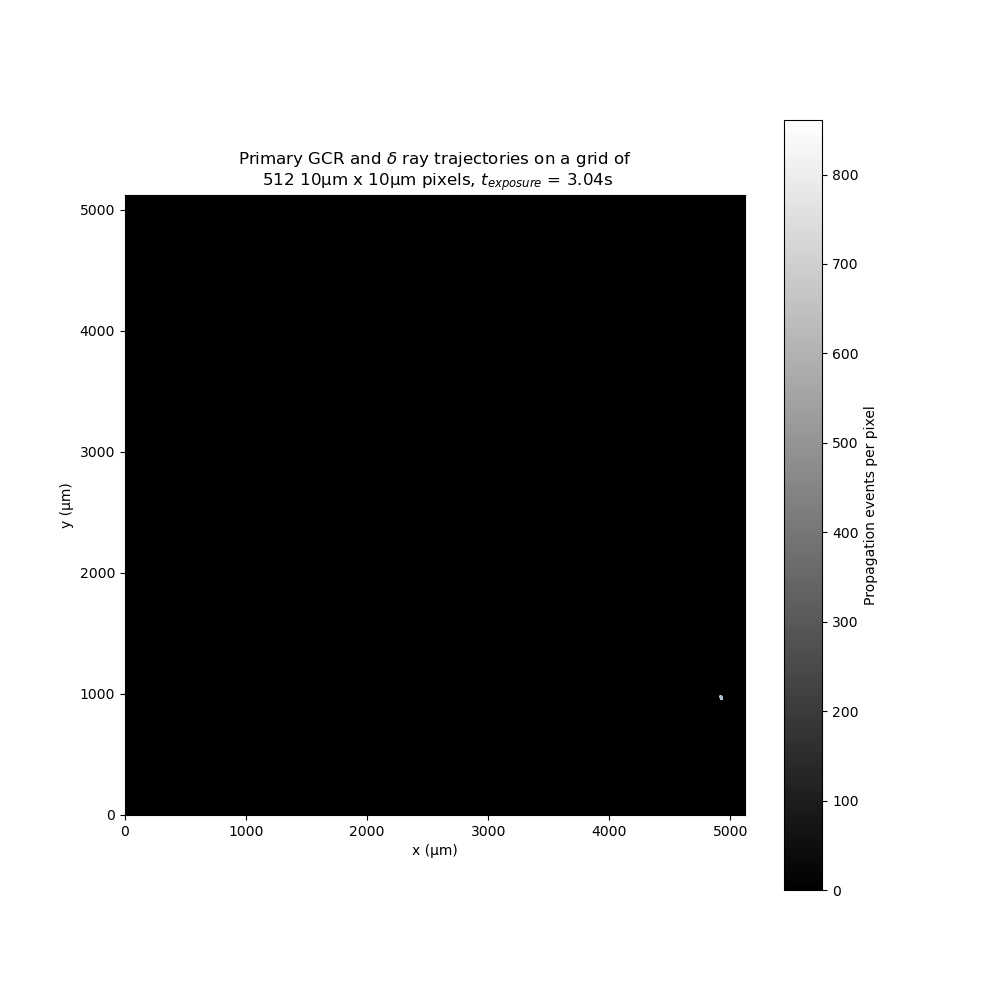

In [4]:
# Plot the heatmap
plt.figure(figsize=(10, 10))
# extent converts pixel indices to physical units (here micrometers)
extent = [0, sim.grid_size * sim.cell_size, 0, sim.grid_size * sim.cell_size]
plt.imshow(heatmap, origin='lower', cmap='gray', extent=extent)
plt.colorbar(label='Propagation events per pixel')

flat_streaks = list(itertools.chain.from_iterable(streaks))

# Overlay the particle trajectories.
for streak in flat_streaks:
    # Each streak record is a tuple; the first element is the list of positions.
    # Each position is a tuple (x, y, z) in micrometers.
    positions, PID, *_ = streak  
    clean_positions = [
        p for p in positions
        if isinstance(p, (tuple, list)) and len(p) == 3 and all(isinstance(v, (int, float)) for v in p)
    ]
    
    if len(clean_positions) < 2:
        continue  # Not enough data to plot a line
    #print(f"PID raw value: {PID}, type: {type(PID)}")

    pos_array = np.array(clean_positions)
    x_vals, y_vals = pos_array[:, 0], pos_array[:, 1]

    color = sim.get_particle_color(PID)
    plt.plot(x_vals, y_vals, '-', color=color, alpha=0.7)

plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.title(r'Primary GCR and $\delta$ ray ' + f'trajectories on a grid of\n {sim.grid_size} 10µm x 10µm pixels, ' + r'$t_{exposure}$' + f' = {sim.dt}s')
plt.show()

In [3]:
heatmap_list = []
streaks_list = []
gcr_counts = []
num_species = len(CosmicRaySimulation.Z_list)

for species_index in tqdm(range(num_species), desc="Running simulation for each species"):
    sim = CosmicRaySimulation(species_index=species_index, grid_size=4088, progress_bar = True)
    heatmap, streaks, primary_gcr_count = sim.run_sim()
    heatmap_list.append(heatmap)
    streaks_list.append(streaks)
    gcr_counts.append((species_names.get(species_index), primary_gcr_count))
    # Delete the local heatmap and streaks to free memory if needed.
    del heatmap, streaks

# Combine all heatmaps element-wise into one final heatmap.
combined_heatmap = np.sum(heatmap_list, axis=0)

# Optionally, free the individual heatmaps list if no longer needed.
#del heatmap_list

Running simulation for each species: 100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


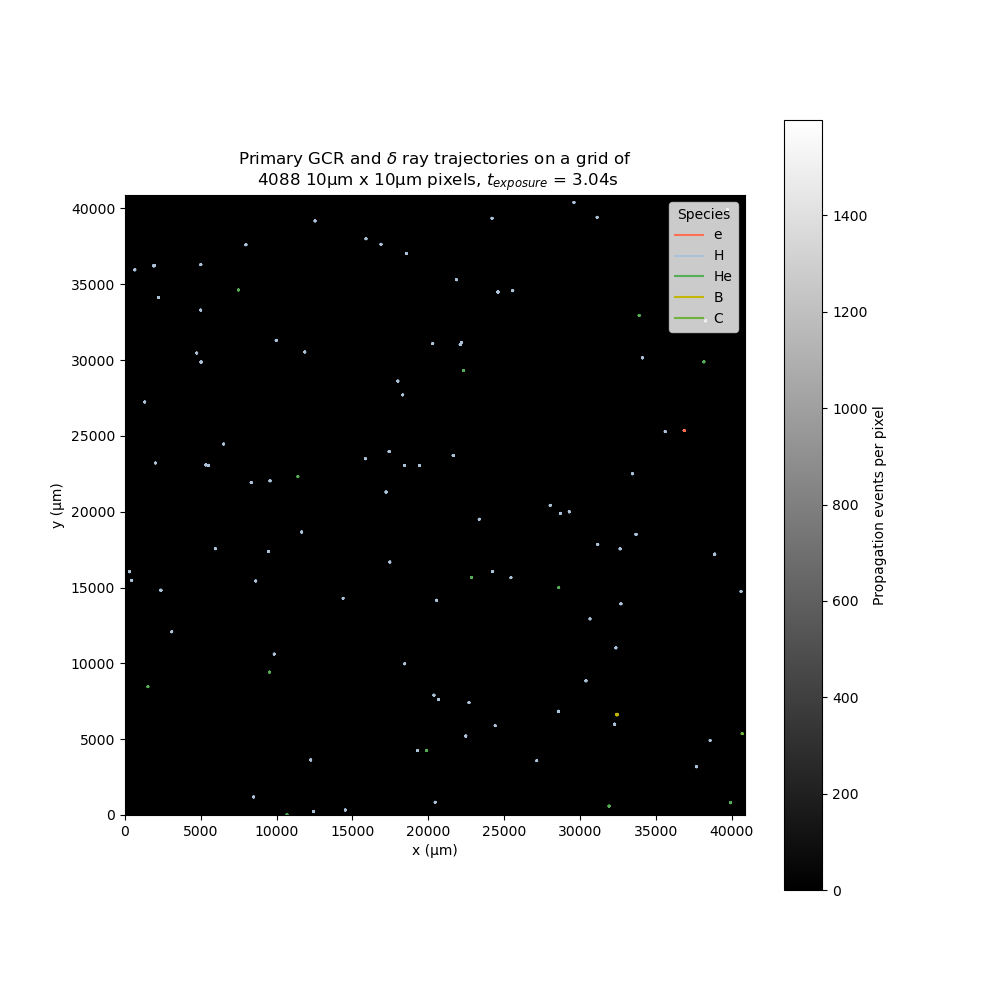

In [8]:
plt.figure(figsize=(10, 10))
extent = [0, sim.grid_size * sim.cell_size, 0, sim.grid_size * sim.cell_size]
plt.imshow(combined_heatmap, origin='lower', cmap='gray', extent=extent)
plt.colorbar(label='Propagation events per pixel')

# Dictionary to store legend handles for each species.
legend_handles = {}

for streak_group in streaks_list:
    for sublist in streak_group:
        for streak in sublist:
            positions, PID, *_ = streak
            if len(positions) < 2:
                continue  # Skip if too few points.
    
            # Extract x and y values.
            x_vals = [p[0] for p in positions if isinstance(p, (list, tuple)) and len(p) >= 2]
            y_vals = [p[1] for p in positions if isinstance(p, (list, tuple)) and len(p) >= 2]
            if len(x_vals) < 2 or len(y_vals) < 2:
                continue
    
            # Determine color from PID.
            color = sim.get_particle_color(PID)
            plt.plot(x_vals, y_vals, '-', color=color, alpha=0.7)
    
            # Extract species index from PID (top 7 bits).
            species_idx = (PID >> (11 + 14)) & ((1 << 7) - 1)
            species_label = species_names.get(species_idx, f"X{species_idx}")
            # Only add one legend entry per species.
            if species_label not in legend_handles:
                handle = mlines.Line2D([], [], color=color, label=species_label)
                legend_handles[species_label] = handle

plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.title(r'Primary GCR and $\delta$ ray ' + f'trajectories on a grid of\n {sim.grid_size} 10µm x 10µm pixels, ' + r'$t_{exposure}$' + f' = {sim.dt}s')
plt.legend(handles=list(legend_handles.values()), title="Species", loc="upper right")
plt.show()

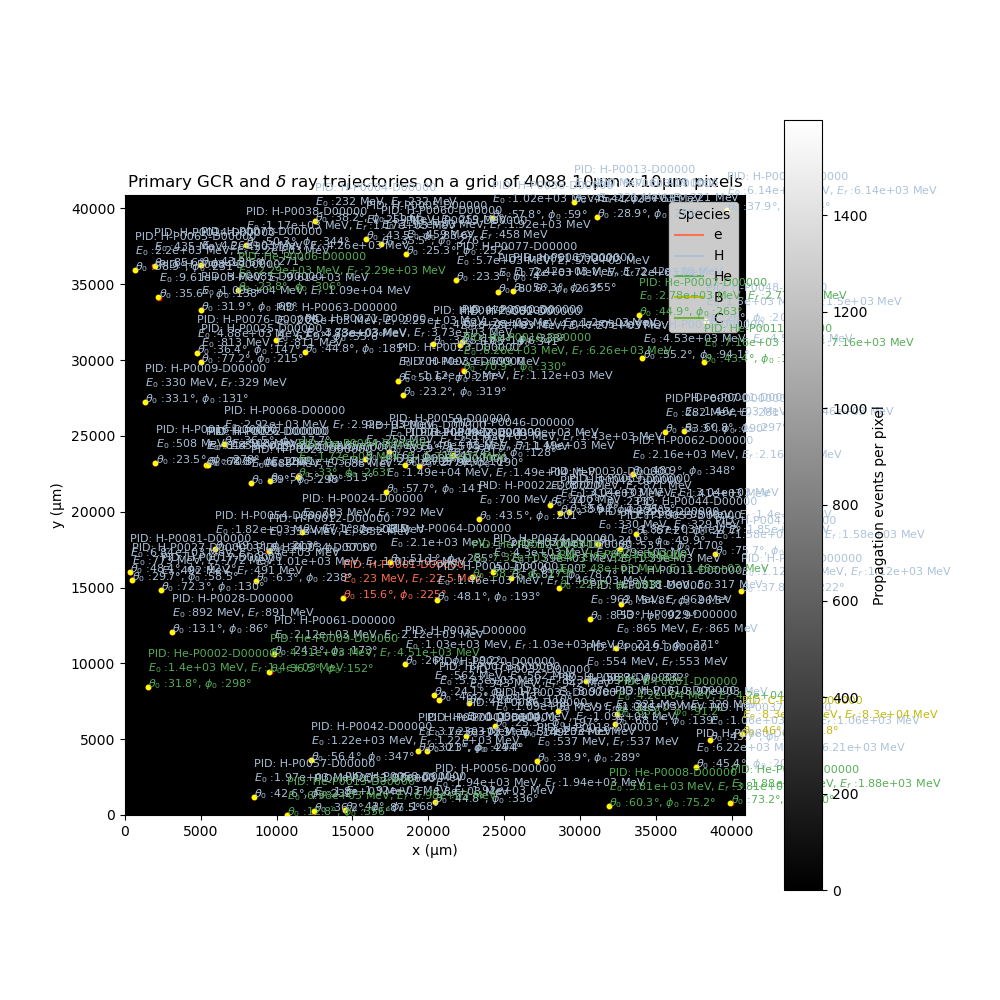

In [21]:
plt.close('all')

plt.figure(figsize=(10, 10))
extent = [0, sim.grid_size * sim.cell_size, 0, sim.grid_size * sim.cell_size]
plt.imshow(combined_heatmap, origin='lower', cmap='gray', extent=extent)
plt.colorbar(label='Propagation events per pixel')

for streak_group in streaks_list:
    for sublist in streak_group:
        for streak in sublist:
            positions, *_ = streak
            if len(positions) < 2:
                continue  # Skip if too few points.
    
            # Extract x and y values.
            x_vals = [p[0] for p in positions if isinstance(p, (list, tuple)) and len(p) >= 2]
            y_vals = [p[1] for p in positions if isinstance(p, (list, tuple)) and len(p) >= 2]
            if len(x_vals) < 2 or len(y_vals) < 2:
                continue
    
            # Determine color from PID.
            color = sim.get_particle_color(PID)
            plt.plot(x_vals, y_vals, '-', color=color, alpha=0.7)
            
            if streak[-1] is True:
                PID = streak[1]
                theta_init = streak[3]
                phi_init = streak[4]
                start_pos = streak[11]
                end_pos = streak[12]
                init_energy = streak[13]
                final_energy = streak[14]
                #pdb.set_trace()
                # Plot the starting (red) and ending (yellow) points.
                plt.scatter(start_pos[0], start_pos[1], color='red', s=10, zorder=5)
                plt.scatter(end_pos[0], end_pos[1], color='yellow', s=10, zorder=5)
                
                # Create an annotation label.
                label_text = (f"PID: {sim.decode_pid(PID)}\n"
                              r'$E_0$'+f" :{init_energy:.3g} MeV, "
                              r'$E_f$'+f" :{final_energy:.3g} MeV\n"
                              r'$\theta_0$'+f" :{(360/(2*np.pi))*theta_init:.3g}°, "
                              r'$\phi_0$'+f" :{(360/(2*np.pi))*phi_init:.3g}°")
                # Annotate the starting point (offset a bit for clarity).
                plt.text(start_pos[0] + 2, start_pos[1] + 2, label_text, 
                         color=color, fontsize=8, zorder=11)

plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.title(r'Primary GCR and $\delta$ ray trajectories on a grid of ' 
          f'{sim.grid_size} 10µm x 10µm pixels')
plt.legend(handles=list(legend_handles.values()), title="Species", loc="upper right")
plt.show()


In [4]:
def plot_delta_ray_energy_histogram(streaks):
    """
    Plot a histogram of the initial energies of all delta rays produced in the simulation.
    Delta rays are identified by having a delta_idx (the lower 14 bits of the PID) strictly greater than zero.
    
    Parameters:
        streaks (list): List of streak tuples. Each tuple should have the following structure:
            (positions, PID, num_steps, theta_init, phi_init, theta, phi, theta0_values,
             x0, y0, z0, start_pos, end_pos, init_en, current_energy)
            where init_en (at index 13) is the initial energy at delta ray creation.
    """
    PID = streaks[0][0][1]
    species_idx = (PID >> (11 + 14)) & ((1 << 7) - 1)
    # Define a mask for the lower 14 bits (delta_idx).
    delta_mask = (1 << 14) - 1  # This is 0x3FFF
    flat_streaks = list(itertools.chain.from_iterable(streaks))
    # Filter for delta rays by checking that the delta_idx field is > 0.
    delta_ray_energies = [st[13] for st in flat_streaks if (st[1] & delta_mask) > 0]

    if not delta_ray_energies:
        print("No delta rays found in the simulation data.")
        return

    # Create logarithmically spaced bins for a better representation of energies.
    bins = np.logspace(np.log10(min(delta_ray_energies)), np.log10(max(delta_ray_energies)), 101)
    #prefactor = (sim.K * Z_mean * CosmicRaySimulation.Z_particle**2) / (A_mean * sim.beta()**2)
    fit = 1/bins

    
    plt.figure(figsize=(10, 6))
    plt.hist(delta_ray_energies, bins=bins, color='orange', alpha=0.7, edgecolor='black')
    plt.plot(bins,fit, color ='k', ls="--")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"Initial $\delta$ ray energy (MeV)")
    plt.ylabel(r"$\frac{dN}{dln(T) dx}$")
    plt.title(r"Histogram of $\delta$ ray initial energies")
    plt.annotate(r'~$\frac{1}{T}$', xy=(1, 1), xytext=(0.06, 30))
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.show()


# Create an Output widget for the plot
plot_output = widgets.Output()

# Create a dropdown for selecting the index
dropdown = widgets.Dropdown(
    options=list(range(len(streaks_list))),
    value=1,  # default index
    description='Index:'
)

# Define the callback that updates the plot in the output widget
def update_plot(change):
    with plot_output:
        plot_output.clear_output(wait=True)
        plot_delta_ray_energy_histogram(streaks_list[change.new])

# Observe changes on the dropdown widget
dropdown.observe(update_plot, names='value')

# Display the dropdown and the output widget
display(dropdown, plot_output)

# Display the initial plot in the output widget
with plot_output:
    plot_delta_ray_energy_histogram(streaks_list[dropdown.value])

Dropdown(description='Index:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

Output()

In [30]:
def get_positions_by_pid(streaks_list, target_pid):
    positions_list = []
    en_changes_list = []
    for streak_group in streaks_list:
        for sublist in streak_group:
            for streak in sublist:
                if streak[1] == target_pid:
                    positions_list.append(streak[0])
                    en_changes_list.append(streak[-7])
    return positions_list, target_pid, en_changes_list


def get_streak_info_by_pid(streaks_list, target_pid, info_option):
    """
    Searches through streaks_list and returns a list of values (one per matching streak)
    for the given info_option. The target_pid is compared to the decoded PID.
    
    Parameters:
      streaks_list : nested list of streak tuples.
      target_pid : str
         The PID in formatted string format (e.g., "H-P0001-D00000").
      info_option : str
         One of: "positions", "initial energy", "final energy", "initial phi", "initial theta"
    
    Returns:
      A list of the requested values from all matching streaks.
    """
    results = []
    # Loop over each group in the nested list.
    for streak_group in streaks_list:
        for sublist in streak_group:
            for streak in sublist:
            # Compare using your decode_pid function so that the formatted PID matches.
                if sim.decode_pid(streak[1]) == target_pid:
                    if info_option == "Positions":
                        results.append(streak[0])
                    elif info_option == "Steps taken (0.1 micron/step)":
                        results.append(streak[2])                        
                    elif info_option == "Initial energy (MeV)":
                        results.append(streak[13])
                    elif info_option == "Final energy (MeV)":
                        results.append(streak[14])
                    elif info_option == "Initial theta (degrees)":
                        results.append(streak[3]*(360/(np.pi*2)))
                    elif info_option == "Initial phi (degrees)":
                        results.append(streak[4]*(360/(np.pi*2)))
    return results

def interactive_get_info(streaks_list):
    """
    Creates an interactive widget that lets the user type in a PID in formatted string format
    and select an option from a drop-down menu. When the button is clicked, the function
    prints the list of values for the selected information from all streaks matching that PID.
    """
    pid_input = widgets.Text(
        value='H-P0001-D00000',
        placeholder='Enter PID (e.g., H-P0001-D00000)',
        description='PID:',
        disabled=False
    )
    info_dropdown = widgets.Dropdown(
        options=["Positions", "Steps taken (0.1 micron/step)", "Initial energy (MeV)", "Final energy (MeV)", "Initial theta (degrees)", "Initial phi (degrees)"],
        value="Initial energy (MeV)",
        description='Info:',
        disabled=False,
    )
    output_area = widgets.Output()

    def on_button_clicked(b):
        with output_area:
            output_area.clear_output()
            result = get_streak_info_by_pid(streaks_list, pid_input.value, info_dropdown.value)
            print(f"Results for {pid_input.value} ({info_dropdown.value}):")
            print(result)

    button = widgets.Button(description="Get Info")
    button.on_click(on_button_clicked)
    
    # Display the widgets together.
    display(pid_input, info_dropdown, button, output_area)

# Example usage:
interactive_get_info(streaks_list)

Text(value='H-P0001-D00000', description='PID:', placeholder='Enter PID (e.g., H-P0001-D00000)')

Dropdown(description='Info:', index=2, options=('Positions', 'Steps taken (0.1 micron/step)', 'Initial energy …

Button(description='Get Info', style=ButtonStyle())

Output()

Calculating kappas, please wait: 100%|██████████| 29/29 [00:09<00:00,  2.96it/s]


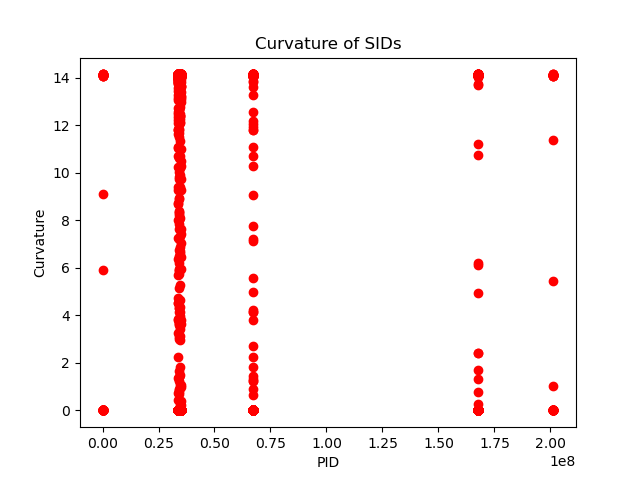

The curviest particle was assigned PID H-P0058-D00022, with curvature of 14
Its parent GCR is: H-P0058-D00000


In [6]:
max_kappa_vals = []
max_kappa_ids = []
particle_totals = []
counter = 0

# Iterate through each streak and compute its curvature profile and count up the number of delta electrons.
for streak_group in tqdm(streaks_list, desc="Calculating kappas, please wait"):
    for sublist in streak_group:
        for streak in sublist:
            positions = streak[0]  # positions is the first element in the streak tuple
            PID = streak[1]        # the second element is the PID
            # Use the static compute_curvature method from the CosmicRaySimulation class
            kappa_values = CosmicRaySimulation.compute_curvature(positions)
            max_kappa_vals.append(max(kappa_values))
            max_kappa_ids.append(PID)
            if counter == 0:
                particle_totals.append(len(sublist))
            else:
                prev_values = np.sum(particle_totals)
                particle_totals.append(len(sublist)-prev_values)
            counter += 1


# Plotting the curvature values vs. PID
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(max_kappa_ids, max_kappa_vals, marker='o', c='r')
ax1.set_xlabel('PID')
ax1.set_ylabel('Curvature')
ax1.set_title('Curvature of SIDs')
plt.show()

# Determine the particle with the maximum curvature.
top_kappa = 0
curviest_PID = None
for pid, kappa in zip(max_kappa_ids, max_kappa_vals):
    if kappa > top_kappa:
        top_kappa = kappa
        curviest_PID = pid

print(f'The curviest particle was assigned PID {sim.decode_pid(curviest_PID)}, with curvature of {top_kappa:.2g}')
curvy_parent_PID = sim.get_parent_pid(curviest_PID)
print(f'Its parent GCR is: {sim.decode_pid(curvy_parent_PID)}')

In [7]:
def convert_pid_strings_to_bits(pid_str_list):
    """
    Given a list of PID strings in the format "Species-Pxxxx-Dyyyyy", 
    return a list of encoded integer PIDs using the encode_pid_string method.
    
    Parameters:
      pid_str_list (list of str): e.g., ["H-P0045-D00023", "He-P0020-D00010"]
    
    Returns:
      List[int]: A list of encoded PID integers.
    """
    encoded_pids = []
    for pid_str in pid_str_list:
        try:
            encoded_pid = CosmicRaySimulation.encode_pid_string(pid_str)
            encoded_pids.append(encoded_pid)
        except ValueError as e:
            print(f"Error encoding PID '{pid_str}': {e}")
    return encoded_pids

def interactive_plot_3d_from_pid_strings(input_str):
    """
    Expects input_str as a comma-separated list of PID strings, e.g.,
    "H-P0045-D00023, He-P0020-D00010". Converts them into encoded PID integers
    using convert_pid_strings_to_bits(), then retrieves and plots the trajectories in 3D.
    """
    try:
        # Split the input string by commas and strip extra spaces.
        pid_str_list = [s.strip() for s in input_str.split(',') if s.strip()]
        # Convert the PID strings into their encoded integer representations.
        encoded_pids = convert_pid_strings_to_bits(pid_str_list)
    except Exception as e:
        print("Error parsing input. Please enter a comma-separated list of PID strings in the format 'Species-Pxxxx-Dyyyyy'.")
        return
    
    plt.close('all')
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # For each encoded PID, retrieve its trajectories and plot them.
    for pid in encoded_pids:
        positions_data, PID, energy_changes = get_positions_by_pid(streaks_list, pid)
        if positions_data:
            for trajectory in positions_data:
                xs, ys, zs = zip(*trajectory)
                ax.plot(xs, ys, zs, marker='o', markersize=1,
                        color=sim.get_particle_color(pid),
                        label=sim.decode_pid(pid))
        else:
            print(f"No trajectory data found for PID: {sim.decode_pid(pid)}")
    
    ax.set_xlabel("x (μm)")
    ax.set_ylabel("y (μm)")
    ax.set_zlabel("z (μm)")
    ax.set_zlim(5, 0)
    ax.set_title("Particle trajectory through SCA")
    ax.legend()
    plt.show()

# Create a Text widget for input.
text_input = widgets.Text(
    value=sim.decode_pid(curvy_parent_PID)+","+sim.decode_pid(curviest_PID),
    placeholder='Enter PID strings separated by commas',
    description='PIDs:',
    disabled=False
)

# Tie the input widget to our interactive function.
interact(interactive_plot_3d_from_pid_strings, input_str=text_input)

interactive(children=(Text(value='H-P0058-D00000,H-P0058-D00022', description='PIDs:', placeholder='Enter PID …

<function __main__.interactive_plot_3d_from_pid_strings(input_str)>

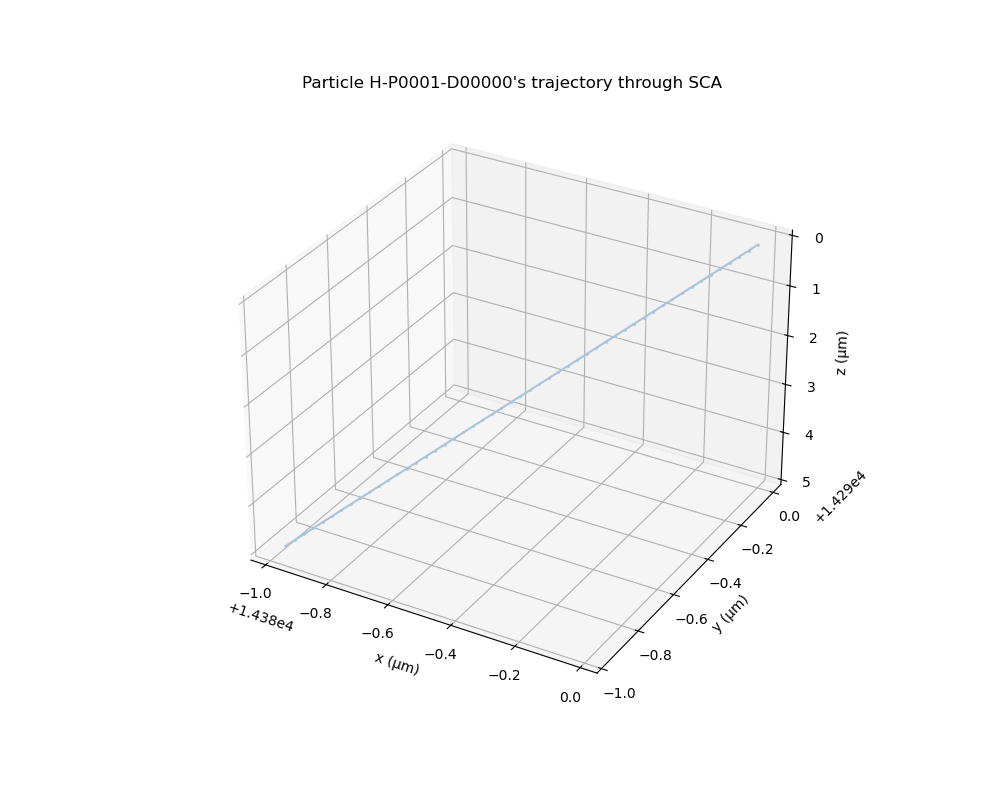

In [10]:
def plot_positions_3d(positions_data, PID):
    """
    Plots a 3D line for each set of positions in positions_data.
    
    Parameters:
      positions_data : list of lists
         Each inner list contains positions (each a tuple or list of x, y, z coordinates).
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    color = sim.get_particle_color(PID)
    # Loop over each series of positions.
    for pos_list in positions_data:
        # Skip empty lists.
        if not pos_list:
            continue
        # Check if positions have at least 3 coordinates.
        if len(pos_list[0]) < 3:
            print("Warning: Position data does not have 3 coordinates. Skipping this series.")
            continue

        xs = [p[0] for p in pos_list]
        ys = [p[1] for p in pos_list]
        zs = [p[2] for p in pos_list]
        
        # Plot a line through the positions with markers at each point.
        ax.plot(xs, ys, zs, color=color, marker='o', markersize=1)
    
    ax.set_xlabel("x (μm)")
    ax.set_ylabel("y (μm)")
    ax.set_zlabel("z (μm)")
    ax.set_zlim(5, 0)
    ax.set_title(f"Particle {sim.decode_pid(PID)}'s trajectory through SCA")
    plt.show()

# Example usage:
# Assuming positions_data is defined (e.g., returned from get_positions_by_pid)
positions, PID, energy_changes = get_positions_by_pid(streaks_list, sim.encode_pid(1,1,0))
plot_positions_3d(positions, PID)

In [11]:
top_n = 50  # Top 50 curviest trajectories
cell_depth = 5 # Thickness of material in microns
# Flatten the nested streaks_list so that we process all species.
all_streaks = [traj for group in streaks_list for sublist in group for traj in sublist]

# Build a sorted list of unique encoded PIDs from the flattened list.
unique_PIDs = sorted({traj[1] for traj in all_streaks})

def plot_trajectories_interactive(selected_indices, selected_PIDs, 
                                  plot_curviest, plot_selected_PIDs, 
                                  plot_starting_points, starting_range):
    """
    Plots the 3D trajectories corresponding to selected curviest indices and/or selected PIDs.
    Additionally, if plot_starting_points is True, plots the starting (x,y,z) locations for all
    trajectories with PID within starting_range.
    """
    plt.close('all')
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # To avoid duplicate plotting, track which PIDs have been plotted.
    plotted_PIDs = set()
    
    # Plot trajectories selected by curviest indices.
    if plot_curviest and selected_indices:
        # Build a list of [encoded PID, curvature, original index] for each trajectory.
        all_kappas = []
        for i in range(len(max_kappa_ids)):
            all_kappas.append([max_kappa_ids[i], max_kappa_vals[i], i])
        # Get the top n curviest trajectories.
        curviest_part_traj = heapq.nlargest(top_n, all_kappas, key=lambda x: x[1])
        
        for idx in selected_indices:
            target_id = curviest_part_traj[idx][2]
            pid = all_streaks[target_id][1]
            initial_energy = all_streaks[target_id][-4]
            final_energy = all_streaks[target_id][-3]
            if pid in plotted_PIDs:
                continue
            plotted_PIDs.add(pid)
            positions = all_streaks[target_id][0]  # List of (x, y, z) tuples.
            xs, ys, zs = zip(*positions)
            color = sim.get_particle_color(pid)
            label = (f'PID {sim.decode_pid(pid)}, ' +
                     r'$E_{initial}$'+f': {initial_energy*1000:.5g} keV\n' +
                     r'$E_{final}$'+f': {final_energy*1000:.5g} keV')
            ax.plot(xs, ys, zs, label=label, color=color, linestyle='-')
            ax.scatter(xs, ys, zs, color=color, marker='+', s=5)
    
    # Plot trajectories selected by PID directly.
    if plot_selected_PIDs and selected_PIDs:
        for traj in all_streaks:
            pid = traj[1]
            initial_energy = traj[-4]
            final_energy = traj[-3]
            if pid in selected_PIDs and pid not in plotted_PIDs:
                plotted_PIDs.add(pid)
                positions = traj[0]
                xs, ys, zs = zip(*positions)
                color = sim.get_particle_color(pid)
                label = (f'PID {sim.decode_pid(pid)}, ' +
                         r'$E_{initial}$'+f': {initial_energy:.3e} MeV\n' +
                         r'$E_{final}$'+f': {final_energy:.3e} MeV')
                ax.plot(xs, ys, zs, label=label, color=color, linestyle='-')
                ax.scatter(xs, ys, zs, color=color, marker='+', s=5)
    
    # Plot starting points for trajectories within the given PID range.
    if plot_starting_points:
        start_pts_x, start_pts_y, start_pts_z = [], [], []
        for traj in all_streaks:
            pid = traj[1]
            if starting_range[0] <= pid <= starting_range[1]:
                start_pt = traj[0][0]
                start_pts_x.append(start_pt[0])
                start_pts_y.append(start_pt[1])
                start_pts_z.append(start_pt[2])
        if start_pts_x:
            ax.scatter(start_pts_x, start_pts_y, start_pts_z,
                       marker='o', s=50, alpha=0.25, color='magenta',
                       label=f'Start pts for PIDs {sim.decode_pid(starting_range[0])} - {sim.decode_pid(starting_range[1])}')
    
    # Set axis labels and title.
    ax.set_xlabel('x (µm)')
    ax.set_ylabel('y (µm)')
    ax.set_zlabel('z (µm)')
    ax.set_title('Selected Trajectories and Starting Points')
    
    # Adjust z-axis: reverse so that z=0 is at the top.
    ax.set_zlim(cell_depth, 0)
    ticks = np.linspace(cell_depth, 0, 6)
    ax.set_zticks(ticks)
    ax.set_zticklabels([f'{int(tick)}' for tick in ticks])
    ax.set_box_aspect([1, 1, 1])
    ax.legend(loc='upper left')
    plt.show()

# --- Build Interactive Widgets ---

# Widget for selecting curviest indices (0 to top_n-1).
multi_index_widget = widgets.SelectMultiple(
    options=list(range(top_n)),
    value=(0,),  # default: the curviest trajectory (index 0)
    description='Indices:',
    disabled=False
)

# Checkbox toggle for plotting trajectories by curviest indices.
plot_curviest_checkbox = widgets.Checkbox(
    value=True,
    description='Plot Curviest',
    disabled=False
)

# Widget for selecting PIDs directly.
# Use (label, value) pairs so that the user sees the decoded PID.
multi_pid_widget = widgets.SelectMultiple(
    options=[(sim.decode_pid(pid), pid) for pid in unique_PIDs],
    value=(unique_PIDs[0],),  # default: first encoded PID
    description='PIDs:',
    disabled=False
)

# Checkbox toggle for plotting selected PIDs.
plot_PIDs_checkbox = widgets.Checkbox(
    value=False,
    description='Plot PIDs',
    disabled=False
)

# Checkbox toggle for plotting starting points.
plot_starting_checkbox = widgets.Checkbox(
    value=False,
    description='Plot Starting Pts',
    disabled=False
)

# IntRangeSlider for choosing the PID range for starting points.
pid_range_slider = widgets.IntRangeSlider(
    value=[min(unique_PIDs), max(unique_PIDs)] if unique_PIDs else [0, 0],
    min=min(unique_PIDs) if unique_PIDs else 0,
    max=max(unique_PIDs) if unique_PIDs else 5000,
    step=1,
    description='PID Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

# Combine all interactive widgets.
interact(plot_trajectories_interactive, 
         selected_indices=multi_index_widget, 
         selected_PIDs=multi_pid_widget,
         plot_curviest=plot_curviest_checkbox,
         plot_selected_PIDs=plot_PIDs_checkbox,
         plot_starting_points=plot_starting_checkbox,
         starting_range=pid_range_slider)


interactive(children=(SelectMultiple(description='Indices:', index=(0,), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9…

<function __main__.plot_trajectories_interactive(selected_indices, selected_PIDs, plot_curviest, plot_selected_PIDs, plot_starting_points, starting_range)>

In [32]:
pid1=sim.encode_pid_string('H-P0067-D00000')
pid2=sim.encode_pid_string('H-P0068-D00000')
print(pid1,' - ',pid2-1)
print(pid2-pid1)

34652160  -  34668543
16384


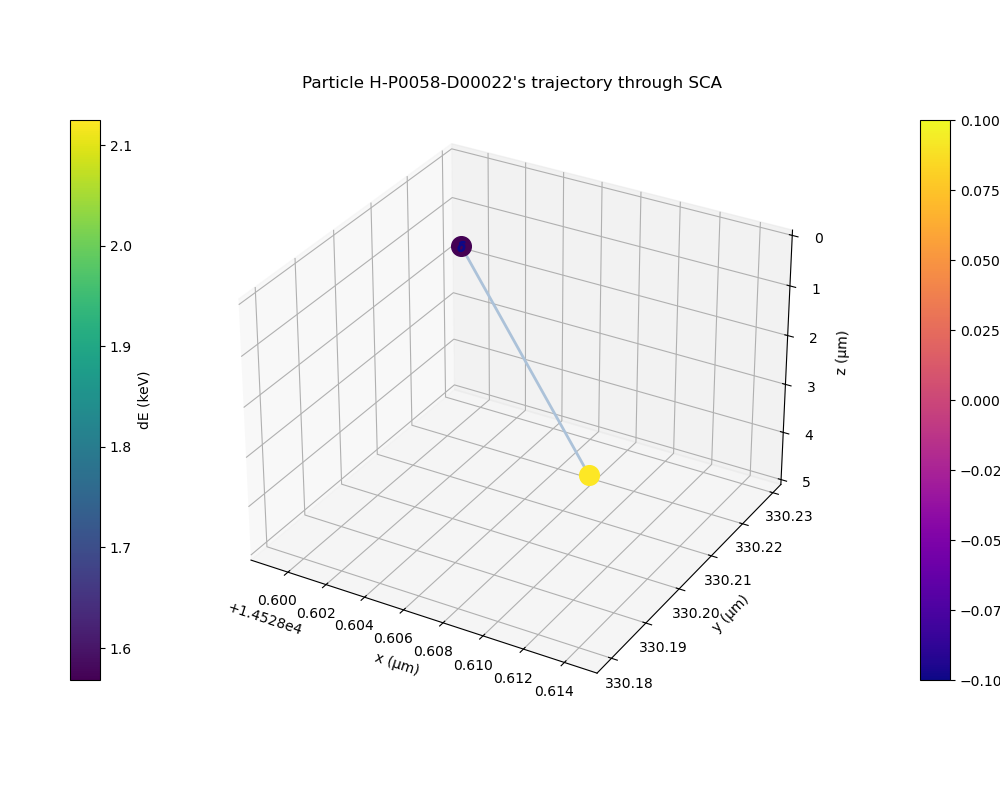

In [12]:
def plot_positions_en(positions_data, energy_changes, PID, offset=0.00):
    """
    Plots a 3D scatter plot for each set of positions in positions_data and connects them with a line.
    At each position, two markers are scatter plotted:
      - A marker for dE (energy change), with its color determined by dE.
      - A marker for T_delta (change in T) using a delta symbol, with its color determined by T_delta (converted to keV).
    The T_delta marker is plotted only if its value differs from the previous position in the same series.
    
    Parameters:
      positions_data : list of lists
         Each inner list contains positions (each a tuple or list of x, y, z coordinates).
      energy_changes : list of lists
         Each inner list corresponds to the matching inner list in positions_data and contains
         tuples of the form (dE, T_delta) for each position. T_delta is in MeV.
      PID : identifier used to get the particle color (if needed).
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get a base color if needed (example from your simulation).
    base_color = sim.get_particle_color(PID)
    
    # Flatten energy_changes to compute global min and max for normalization and multiply values by 1000 to convert from MeV to keV.
    all_dE = [pair[0] * 1000 for sublist in energy_changes for pair in sublist]
    all_Tdelta_keV = [pair[1] * 1000 for sublist in energy_changes for pair in sublist]
    
    norm_dE = colors.Normalize(vmin=min(all_dE), vmax=max(all_dE))
    norm_Tdelta = colors.Normalize(vmin=min(all_Tdelta_keV), vmax=max(all_Tdelta_keV))
    
    cmap_dE = plt.get_cmap('viridis')
    cmap_T = plt.get_cmap('plasma')
    
    # Loop over each series.
    for pos_series, energy_series in zip(positions_data, energy_changes):
        # Skip if either series is empty.
        if not pos_series or not energy_series:
            continue
        
        # Check if positions have at least 3 coordinates.
        if len(pos_series[0]) < 3:
            print("Warning: Position data does not have 3 coordinates. Skipping this series.")
            continue
        
        # Lists to store coordinates for the line
        xs, ys, zs = [], [], []
        previous_Tdelta = None
        
        for i, (pos, energy_pair) in enumerate(zip(pos_series, energy_series)):
            dE, Tdelta = energy_pair
            x, y, z = pos[0], pos[1], pos[2]
            
            # Accumulate points for the line plot.
            xs.append(x)
            ys.append(y)
            zs.append(z)
            
            # Get colors for dE and Tdelta and multiply by 1000 for keV conversion.
            color_dE = cmap_dE(norm_dE(dE * 1000))
            color_Tdelta = cmap_T(norm_Tdelta(Tdelta * 1000))
            
            # Scatter plot for dE (circle marker) with a white edge.
            ax.scatter(x, y, z, color=color_dE, marker='o', s=200, zorder=2)
            
            # Scatter plot for T_delta (delta marker) with a black edge,
            # plotted only if Tdelta has changed from the previous value.
            if i == 0 or Tdelta != previous_Tdelta:
                ax.scatter(x + offset, y + offset, z + offset, color=color_Tdelta, marker=r'$\delta$', s=50, zorder=1)
            
            previous_Tdelta = Tdelta
        
        # Connect the points with a line.
        ax.plot(xs, ys, zs, color=base_color, linewidth=2)
    
    ax.set_xlabel("x (μm)")
    ax.set_ylabel("y (μm)")
    ax.set_zlabel("z (μm)")
    ax.set_zlim(5, 0)
    ax.set_title(f"Particle {sim.decode_pid(PID)}'s trajectory through SCA")
    
    # Create ScalarMappable objects for the colorbars.
    sm_dE = cm.ScalarMappable(cmap=cmap_dE, norm=norm_dE)
    sm_dE.set_array([])
    sm_T = cm.ScalarMappable(cmap=cmap_T, norm=norm_Tdelta)
    sm_T.set_array([])
    
    # Create two colorbars on opposite sides of the figure.
    # Left colorbar for dE.
    cax_left = fig.add_axes([0.07, 0.15, 0.03, 0.7])
    cbar_dE = fig.colorbar(sm_dE, cax=cax_left)
    cbar_dE.set_label("dE (keV)")
    
    # Right colorbar for T_delta.
    cax_right = fig.add_axes([0.92, 0.15, 0.03, 0.7])
    cbar_T = fig.colorbar(sm_T, cax=cax_right)
    cbar_T.set_label(r"$\delta$ ray generation (keV)")
    
    plt.show()

positions, PID, energy_changes = get_positions_by_pid(streaks_list, curviest_PID)
plot_positions_en(positions, energy_changes, curviest_PID)

In [13]:
plt.close('all')

def find_longest_pid(streaks_list):
    """
    Iterates over a nested streaks_list to identify the PID that has the longest trajectory.
    
    The streaks_list is expected to be nested as follows:
      - For each streak_group in streaks_list:
          For each sublist in streak_group:
              For each streak in sublist:
                  - streak[0] is the positions data (a list of (x, y, z) positions)
                  - streak[1] is the encoded PID for that particle.
    
    Returns:
      tuple: (pid, length)
         - pid: the encoded PID corresponding to the trajectory with the maximum number of positions.
         - length: the number of positions in that trajectory.
         
      If no streaks are found, returns (None, 0).
    """
    max_length = 0
    max_pid = None
    
    # Loop over the nested structure.
    for streak_group in streaks_list:
        for sublist in streak_group:
            for streak in sublist:
                # Each streak is expected to have the format [positions, pid]
                positions = streak[0]
                pid = streak[1]
                trajectory_length = len(positions)
                if trajectory_length > max_length:
                    max_length = trajectory_length
                    max_pid = pid
                    
    return max_pid, max_length

long_particle, total_steps = find_longest_pid(streaks_list)
print(f'The longest traveling particle was {sim.decode_pid(long_particle)}',
      f'with {total_steps} steps,\n which, with a step size of 0.1 micron, is {total_steps*sim.step_size} microns')

The longest traveling particle was H-P0014-D00000 with 657 steps,
 which, with a step size of 0.1 micron, is 65.7 microns


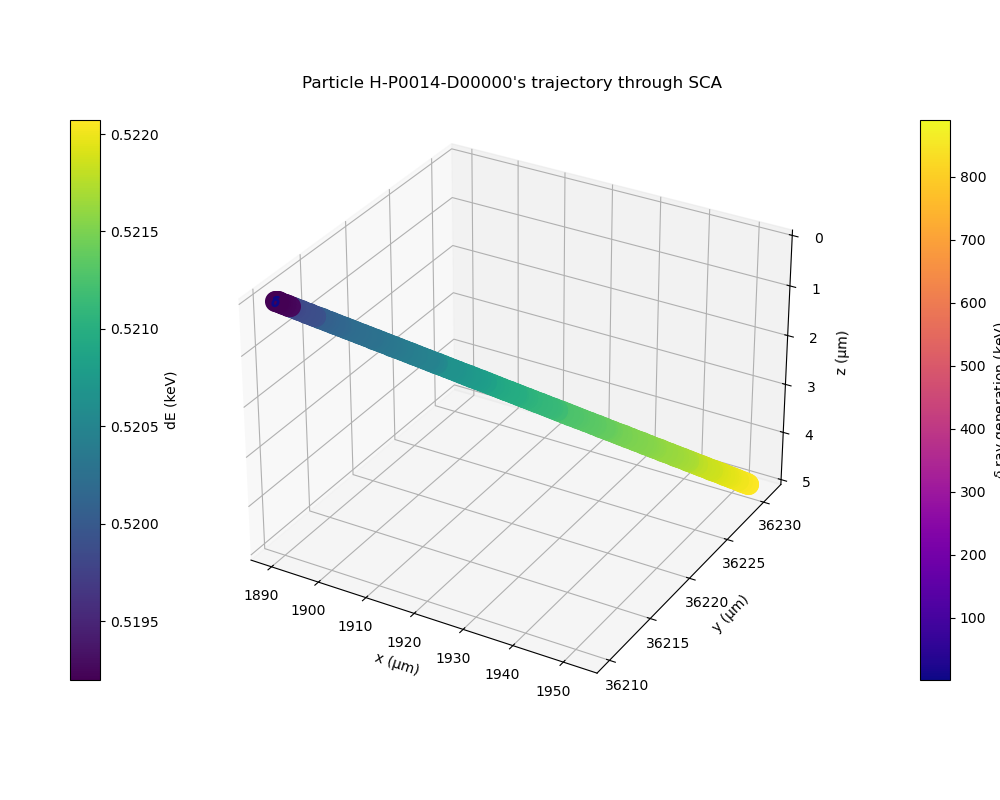

In [14]:
positions, PID, energy_changes = get_positions_by_pid(streaks_list, long_particle)
plot_positions_en(positions, energy_changes, PID)

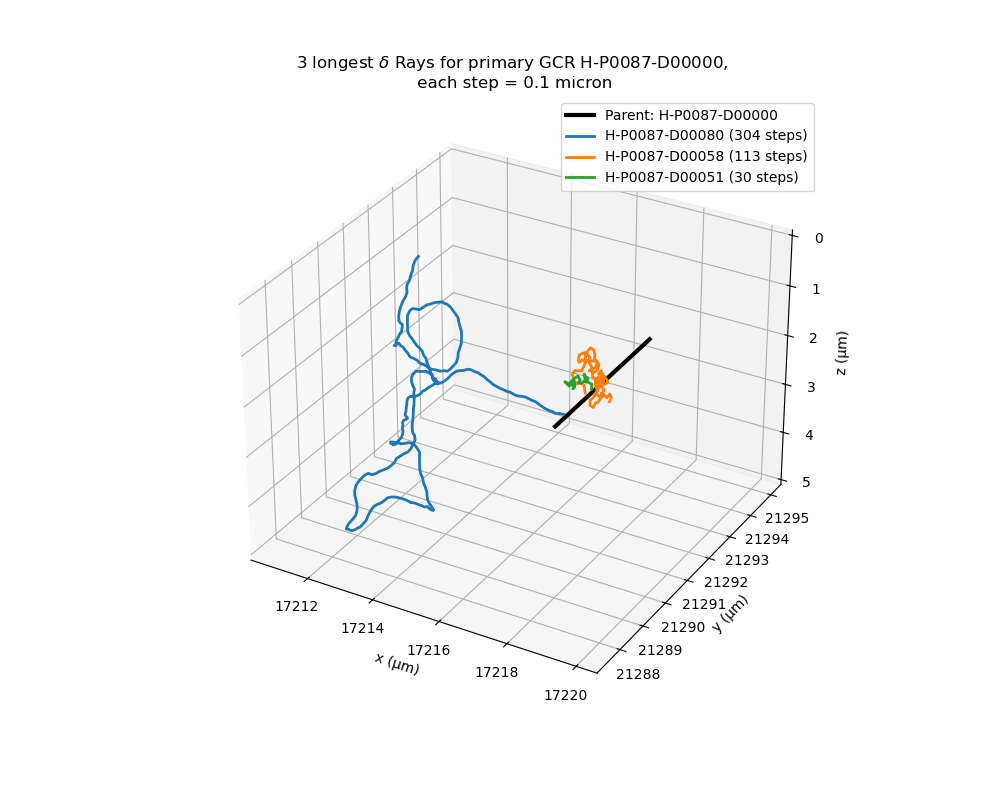

In [29]:
def plot_top_delta_rays(streaks_list, primary_pid, x = 1):
    """
    For a given primary particle PID, identifies and plots the top x longest delta ray trajectories.
    
    The streaks_list is assumed to be nested as follows:
      - For each streak_group in streaks_list:
          For each sublist in streak_group:
              For each streak in sublist:
                  streak[0] is a list of (x, y, z) positions.
                  streak[1] is the encoded PID for that particle.
    
    The function filters out the primary trajectory and then uses a bitwise comparison to check if a delta ray belongs to that primary.
    
    It then sorts the delta rays by trajectory length and plots the top 5.
    
    Parameters:
      streaks_list : nested list structure containing the streak data.
      primary_pid : the encoded primary particle PID.
    """
    # First, locate the parent's trajectory in the nested structure.
    parent_trajectory = None
    for streak_group in streaks_list:
        for sublist in streak_group:
            for streak in sublist:
                positions = streak[0]
                pid = streak[1]
                if pid == primary_pid:
                    parent_trajectory = positions
                    break
            if parent_trajectory is not None:
                break
        if parent_trajectory is not None:
            break

    if parent_trajectory is None:
        print("Parent trajectory not found for PID:", primary_pid)
    # List to store tuples: (delta_ray_pid, trajectory_length, positions)
    delta_rays = []
    
    # Loop over the nested structure.
    for streak_group in streaks_list:
        for sublist in streak_group:
            for streak in sublist:
                positions = streak[0]
                pid = streak[1]
                # Exclude the primary trajectory itself and check using a bitwise operator.
                # This condition checks if the bits in primary_pid are also present in pid.
                if pid != primary_pid and (pid & primary_pid) == primary_pid:
                    delta_rays.append((pid, len(positions), positions))
    
    # Sort by trajectory length (largest first).
    delta_rays.sort(key=lambda tup: tup[1], reverse=True)
    
    # Take the top x.
    x=x
    topx = delta_rays[:x]
    
    if not topx:
        print("No delta rays found for primary PID", primary_pid)
        return
        
    # Create a 3D plot.
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    if parent_trajectory is not None:
        xs_parent = [p[0] for p in parent_trajectory]
        ys_parent = [p[1] for p in parent_trajectory]
        zs_parent = [p[2] for p in parent_trajectory]
        ax.plot(xs_parent, ys_parent, zs_parent, color='k', linewidth=3,
                label=f"Parent: {sim.decode_pid(primary_pid)}")
    

    
    # Use a colormap with enough distinct colors.
    cmap = plt.get_cmap('tab10')
    
    for i, (pid, length, positions) in enumerate(topx):
        # Extract x, y, and z coordinates.
        xs = [p[0] for p in positions]
        ys = [p[1] for p in positions]
        zs = [p[2] for p in positions]
        
        color = cmap(i)  # choose a different color for each delta ray
        
        # Plot the trajectory line.
        ax.plot(xs, ys, zs, color=color, linewidth=2, 
                label=f"{sim.decode_pid(pid)} ({length} steps)")
    
    ax.set_xlabel("x (μm)")
    ax.set_ylabel("y (μm)")
    ax.set_zlabel("z (μm)")
    ax.set_zlim(5, 0)
    ax.set_title(f"{x} longest "+r"$\delta$ "+f"Rays for primary GCR {sim.decode_pid(primary_pid)},\n each step = 0.1 micron")
    ax.legend()
    
    plt.show()

# Example usage:
# Assuming streaks_list is defined and curvy_parent_PID is the primary PID of interest.
#plot_top_delta_rays(streaks_list, curvy_parent_PID, x=1)
plot_top_delta_rays(streaks_list, sim.encode_pid_string('H-P0087-D00000'), x=3)

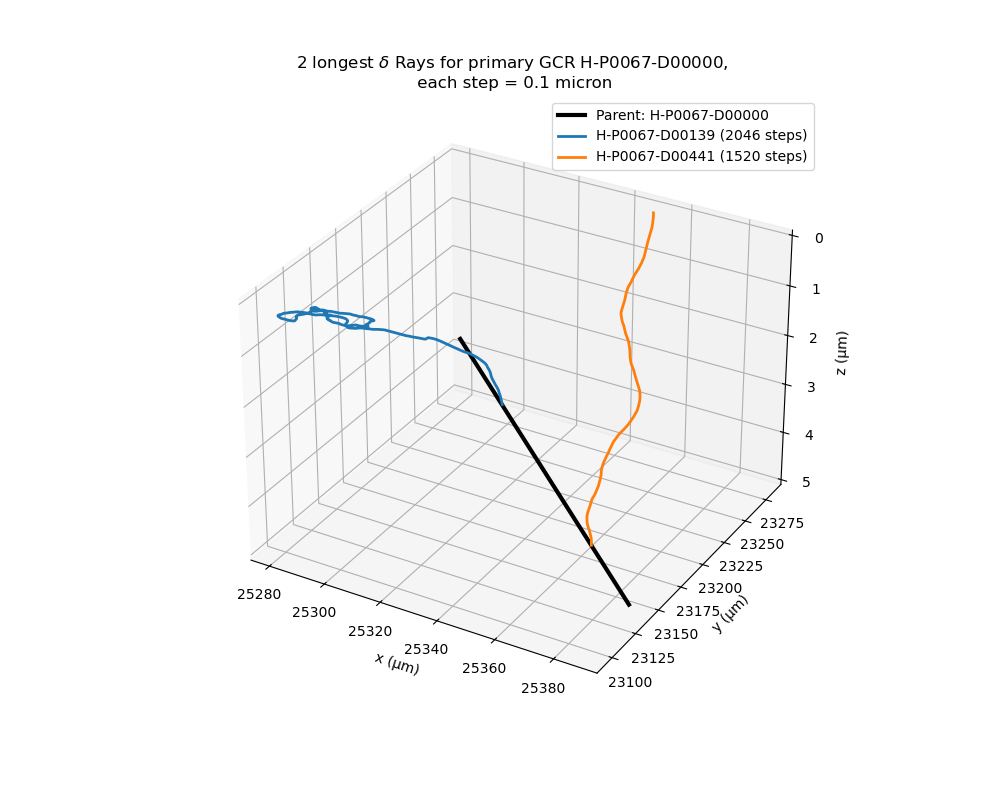

In [68]:
#plot_top_delta_rays(streaks_list, sim.encode_pid_string('H-P0067-D00000'), x=2)

In [23]:
primary_delta_counts = {}
total_species_counts = {}
for streak_group in tqdm(streaks_list, desc="Extracting delta ray counts by species"):
        for sublist in streak_group:
            for streak in sublist:
                if streak[16] is True:
                    PID = streak[1]
                    delta_count = streak[-2]
                    # If the same primary appears multiple times, you may want to sum the counts.
                    key = sim.decode_pid(PID)
                    if key in primary_delta_counts:
                        primary_delta_counts[key] += delta_count
                    else:
                        primary_delta_counts[key] = delta_count

primary_PIDs = list(primary_delta_counts.keys())
delta_counts = list(primary_delta_counts.values())

for key, count in primary_delta_counts.items():
    # Extract the species identifier (e.g. "e-P0001") from the key "e-P0001-D00001".
    species_label = key.split("-D")[0]
    total_species_counts[species_label] = total_species_counts.get(species_label, 0) + count

rejected_counts = {}

for streak_group in tqdm(streaks_list, desc="Rejecting short delta rays..."):
    for sublist in streak_group:
        for streak in sublist:
            # Each streak record has positions and PID.
            positions, PID, *_ = streak
            if len(positions) < 2:
                # Define a key for the species using the decoded PID.
                key = sim.decode_pid(PID)
                # Add the number of delta rays (len(positions)) to the rejected count for that species.
                rejected_counts[key] = rejected_counts.get(key, 0) + len(positions)
                continue  # Skip if too few points.

species_rejected_counts = {}

for key, count in rejected_counts.items():
    # Extract the species identifier (e.g. "e-P0001") from the key "e-P0001-D00001".
    species_label = key.split("-D")[0]
    species_rejected_counts[species_label] = species_rejected_counts.get(species_label, 0) + count
    
print(f'The total number of delta rays generated by primary cosmic rays was = {np.sum(delta_counts)}\n')

# Aggregate total_delta_dict by species.
total_species_counts = {}
for key, count in primary_delta_counts.items():
    # The species key is everything before "-D"
    species_key = key.split("-D")[0]
    total_species_counts[species_key] = total_species_counts.get(species_key, 0) + count

# Create the difference dictionary using keys from rejected_species_counts.
difference_dict = {}
for species, rejected_count in species_rejected_counts.items():
    total_count = total_species_counts.get(species, 0)
    difference_dict[species] = total_count - rejected_count
    
print("Number of delta rays per primary GCR:", total_species_counts, "\n ")

print("Number of rejected delta rays per primary cosmic ray:", species_rejected_counts,"\n ")
print("Difference (Accepted delta rays per GCR):", difference_dict,"\n ")
print(f'The total number of delta rays accepted was = {sum(difference_dict.values())}\n ')

print(f'Average acceptance rate = {(sum(difference_dict.values())/np.sum(delta_counts))*100:.3g}%\n ')

percent_accepted = {
    species: f"{(difference_dict.get(species, 0) / total_species_counts[species] * 100):.3g}%"
    for species in total_species_counts
    if total_species_counts[species] != 0 }

print(f"Acceptance rate per primary GCR is: {percent_accepted}")

Rejecting short delta rays...: 100%|██████████| 29/29 [00:00<00:00, 1199.76it/s]

The total number of delta rays generated by primary cosmic rays was = 11854

Number of delta rays per primary GCR: {'e-P0001': 63, 'H-P0001': 73, 'H-P0002': 96, 'H-P0003': 89, 'H-P0004': 61, 'H-P0005': 82, 'H-P0006': 51, 'H-P0007': 89, 'H-P0008': 103, 'H-P0009': 61, 'H-P0010': 54, 'H-P0011': 58, 'H-P0012': 61, 'H-P0013': 83, 'H-P0014': 50, 'H-P0015': 82, 'H-P0016': 67, 'H-P0017': 68, 'H-P0018': 107, 'H-P0019': 64, 'H-P0020': 55, 'H-P0021': 63, 'H-P0022': 97, 'H-P0023': 89, 'H-P0024': 52, 'H-P0025': 55, 'H-P0026': 118, 'H-P0027': 67, 'H-P0028': 83, 'H-P0029': 54, 'H-P0030': 50, 'H-P0031': 64, 'H-P0032': 63, 'H-P0033': 50, 'H-P0034': 54, 'H-P0035': 97, 'H-P0036': 147, 'H-P0037': 63, 'H-P0038': 53, 'H-P0039': 130, 'H-P0040': 79, 'H-P0041': 174, 'H-P0042': 1613, 'H-P0043': 111, 'H-P0044': 133, 'H-P0045': 60, 'H-P0046': 151, 'H-P0047': 53, 'H-P0048': 256, 'H-P0049': 54, 'H-P0050': 78, 'H-P0051': 74, 'H-P0052': 76, 'H-P0053': 177, 'H-P0054': 67, 'H-P0055': 74, 'H-P0056': 64, 'H-P0057': 100, 

In [28]:
plt.close("all")

In [20]:
# --- Code for 'movie' creation using a series of combined
# heatmaps over all species as the 'frames' of the movie---
num_of_frames = 4
frames = []      # Each element will be a list of heatmaps (one per species)
all_streaks = []
all_counts = []

for i in tqdm(range(num_of_frames), desc="Generating frames"):
    heatmap_list = []
    streaks_list = []
    gcr_counts = []
    num_species = len(CosmicRaySimulation.Z_list)
    
    for species_index in range(num_species):
        sim = CosmicRaySimulation(species_index=species_index, grid_size=4088, progress_bar=True)
        heatmap, streaks, primary_gcr_count = sim.run_sim()
        heatmap_list.append(heatmap)  # heatmap is expected to be a 2D numpy array.
        streaks_list.append(streaks)
        gcr_counts.append((species_names.get(species_index), primary_gcr_count))
        # Free the local variables if needed.
        del heatmap, streaks, primary_gcr_count
        
    frames.append(heatmap_list)
    all_streaks.append(streaks_list)
    all_counts.append(gcr_counts)
    del heatmap_list, streaks_list, gcr_counts


Generating frames: 100%|██████████| 4/4 [01:27<00:00, 21.80s/it]


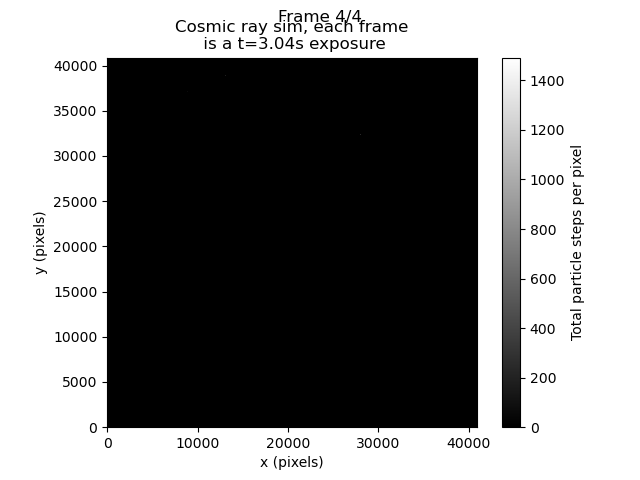

In [21]:

# For each frame, sum over species to get one combined 2D heatmap
def combined_heatmap(frame_index):
    # Sum the list of heatmaps (for all species in one frame) element-wise.
    return np.sum(frames[frame_index], axis=0)

num_frames = len(frames)

# --- Set up the figure for animation ---
fig, ax = plt.subplots()
# Use the combined heatmap for the first frame.
extent = [0, sim.grid_size * sim.cell_size, 0, sim.grid_size * sim.cell_size]
im = ax.imshow(combined_heatmap(0), cmap="gray", interpolation='nearest',
               origin='lower', extent = extent, animated=True)
cb = plt.colorbar(im, ax=ax)
cb.set_label("Total particle steps per pixel")  # Set an appropriate label based on your simulation.
ax.set_title("Cosmic ray sim, each frame\n is a t=3.04s exposure")
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')

# --- Update function for animation ---
def update_frame(frame_index):
    im.set_array(combined_heatmap(frame_index))
    fig.suptitle(f"Frame {frame_index+1}/{num_frames}")
    return [im]

# Create the animation object
ani = animation.FuncAnimation(fig, update_frame, frames=num_frames,
                              interval=2000, blit=True, repeat=False)

# Show the animation (if in an interactive environment)
# plt.show()

# Optionally, save the animation as a video file:
ani.save('cosmic_ray_heatmaps.mp4', writer='ffmpeg')


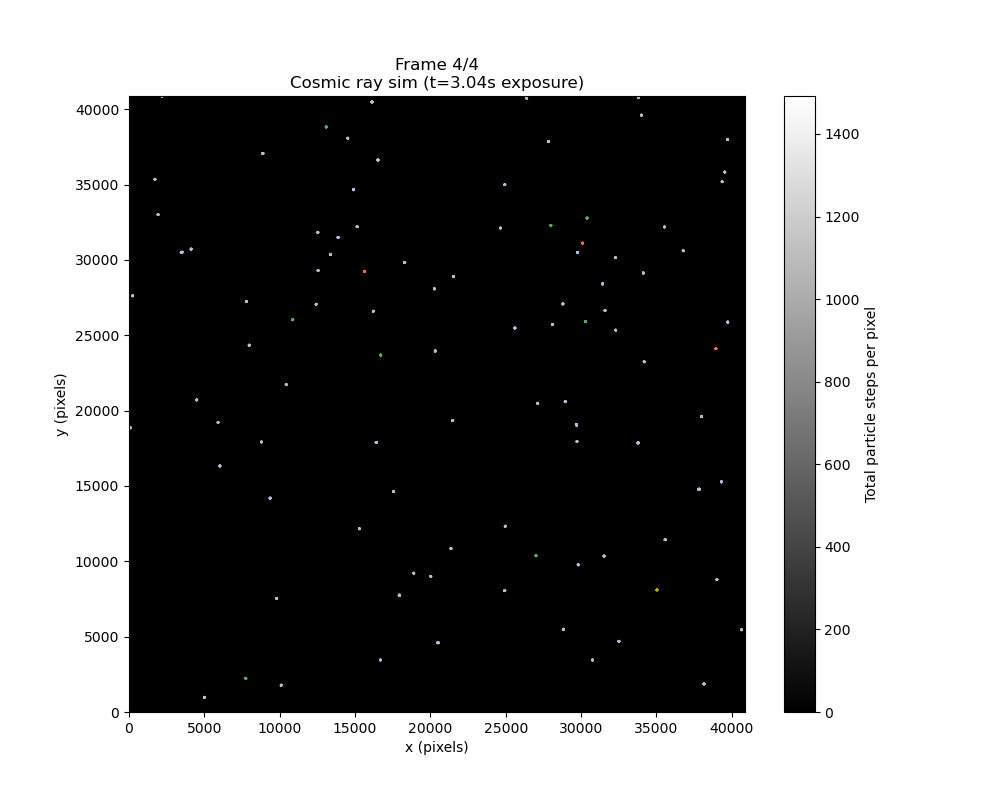

In [22]:
# --- Helper to combine heatmaps for each frame ---
def combined_heatmap(frame_index):
    return np.sum(frames[frame_index], axis=0)  # Sum over species

# --- Setup plot ---
fig, ax = plt.subplots(figsize=(10, 8))

# Use first frame's data to set up initial image
initial_heat = combined_heatmap(0)
im = ax.imshow(initial_heat, cmap="gray", interpolation='nearest', origin='lower',
               extent=[0, initial_heat.shape[1] * sim.cell_size, 0, initial_heat.shape[0] * sim.cell_size])

# Set axis labels and colorbar
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
cb = plt.colorbar(im, ax=ax)
cb.set_label("Total particle steps per pixel")

# Fix the axis limits so they stay consistent across frames
ax.set_xlim(0, initial_heat.shape[1] * sim.cell_size)
ax.set_ylim(0, initial_heat.shape[0] * sim.cell_size)
ax.set_autoscale_on(False)

# --- Animation update function ---
def update_frame(frame_index):
    # Update heatmap data
    heat = combined_heatmap(frame_index)
    im.set_array(heat)
    
    # Update title
    ax.set_title(f"Frame {frame_index+1}/{num_frames}\nCosmic ray sim (t=3.04s exposure)")
    
    # Clear old streak lines (preserves the heatmap and colorbar)
    for line in ax.lines[:]:  # Use a copy of the list to avoid modifying while iterating
        line.remove()

    
    # Plot new streaks
    current_streaks_list = all_streaks[frame_index]
    for streak_group in current_streaks_list:
        for sublist in streak_group:
            for streak in sublist:
                positions, PID, *_ = streak
                if len(positions) < 2:
                    continue
                x_vals = [p[0] for p in positions if isinstance(p, (list, tuple)) and len(p) >= 2]
                y_vals = [p[1] for p in positions if isinstance(p, (list, tuple)) and len(p) >= 2]
                if len(x_vals) < 2 or len(y_vals) < 2:
                    continue
                color = sim.get_particle_color(PID)
                ax.plot(x_vals, y_vals, '-', color=color, alpha=0.7)
    
    return [im]

# --- Create animation ---
ani = animation.FuncAnimation(fig, update_frame, frames=num_frames,
                              interval=1500, blit=False, repeat=False)

# Save or show the animation
# plt.show()  # Uncomment for interactive environments
ani.save('cosmic_ray_heatmaps_fixed.mp4', writer='ffmpeg')
